# Import libraries and set configs

In [1]:
import sys
sys.path.append('..')

import os
import json
import joblib
import random
import warnings
from collections import defaultdict
import numpy as np
import pandas as pd
from glob import glob
from optimizer.optimizer import Optimizer
from os import environ
from datetime import timedelta
from tqdm.auto import tqdm
from datetime import datetime

from eli5.sklearn import PermutationImportance

import optuna
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, precision_score

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('fivethirtyeight')

from colorama import Style, Fore

# Set environment variable
environ["ENV"] = "optimize"

from config.config import ConfigFactory
from indicators import indicators

from api.tvdatafeed.main import TvDatafeed, Interval
from constants.constants import tv_username, tv_password


class CFG:
    load = False
    historical = False
    create_dataset = False
    cls_target_ratio_tp = 1.03
    cls_target_ratio_sl = 1.03
    ttype = 'both'
    patterns_to_filter = ['STOCH_RSI_Volume24']
    select_features = False
    optimize = False
    n_repeats = 1
    n_folds = 8
    last_date = '2024-03-01'
    agg_periods = [24, 72]
    agg_funcs = [np.min, np.max, np.mean, np.median, np.std]

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

tqdm.pandas()

warnings.simplefilter(action='ignore', category=(FutureWarning, pd.errors.PerformanceWarning))

# Load data

### Load STOCH_RSI buy data

In [2]:
work_timeframe = '1h'
higher_timeframe = '4h'
opt_limit = 100000

ttype = 'buy'
pattern = ['STOCH', 'RSI', 'Volume24']
indicator_list = pattern
indicator_list_higher = ['Trend', 'MACD']

# Get configs
configs = ConfigFactory.factory(environ).configs
configs['Indicator_list'] = indicator_list
configs['Higher_TF_indicator_list'] = indicator_list_higher
configs['Timeframes']['work_timeframe'] = work_timeframe
configs['Timeframes']['higher_timeframe'] = higher_timeframe

optim_dict = {
                'RSI': {
                        'timeperiod': [14], 
                        'low_bound': [35]
                       },
                'STOCH': {
                          'fastk_period': [9],
                          'slowk_period': [7],
                          'slowd_period': [3], 
                          'low_bound': [25]
                        }
             }

if CFG.load:
  print(f'Timeframe is {work_timeframe}/{higher_timeframe}, trade type is {ttype}')
  opt = Optimizer(pattern, optim_dict, clean=False, **configs)
  min_time = datetime.now().replace(microsecond=0, second=0, minute=0) - pd.to_timedelta(365 * 10, unit='D')
  stat = opt.optimize(pattern, ttype, opt_limit, load=True, op_type='ml', historical=CFG.historical, min_time=min_time)
  display(stat) # 31060

### Load STOCH_RSI sell data

In [3]:
work_timeframe = '1h'
higher_timeframe = '4h'
opt_limit = 100000

ttype = 'sell'
pattern = ['STOCH', 'RSI', 'Volume24']
indicator_list = pattern
indicator_list_higher = ['Trend', 'MACD']

# Get configs
configs = ConfigFactory.factory(environ).configs
configs['Indicator_list'] = indicator_list
configs['Higher_TF_indicator_list'] = indicator_list_higher
configs['Timeframes']['work_timeframe'] = work_timeframe
configs['Timeframes']['higher_timeframe'] = higher_timeframe

optim_dict = {
                'RSI': {
                        'timeperiod': [14], 
                        'low_bound': [35]
                       },
                'STOCH': {
                          'fastk_period': [9],
                          'slowk_period': [7],
                          'slowd_period': [3], 
                          'low_bound': [25]
                        }
             }

if CFG.load:
  print(f'Timeframe is {work_timeframe}/{higher_timeframe}, trade type is {ttype}')
  opt = Optimizer(pattern, optim_dict, clean=False, **configs)
  min_time = datetime.now().replace(microsecond=0, second=0, minute=0) - pd.to_timedelta(365 * 10, unit='D')
  stat = opt.optimize(pattern, ttype, opt_limit, load=False, op_type='ml', historical=CFG.historical, min_time=min_time)
  display(stat) # 23629

# Test loaded data

### Remove dataframe files with the biggest number of missing data

In [4]:
counter = 0 

tickers_1h = glob('../optimizer/ticker_dataframes/*_1h.pkl')
for ticker in tqdm(tickers_1h[3:]):
    df = pd.read_pickle(ticker)
    nunique = df['time'].diff()[1:].nunique()
    if nunique > 1:
        count = df[df['time'].diff().astype('timedelta64[h]') != 1].shape[0]
        if count > 200:
            print(ticker, nunique, count)
            os.remove(ticker)
            os.remove(ticker[:-6] + '4h.pkl')
            
counter

  0%|          | 0/2743 [00:00<?, ?it/s]

0

### Plot time vs index for some of dataframe files

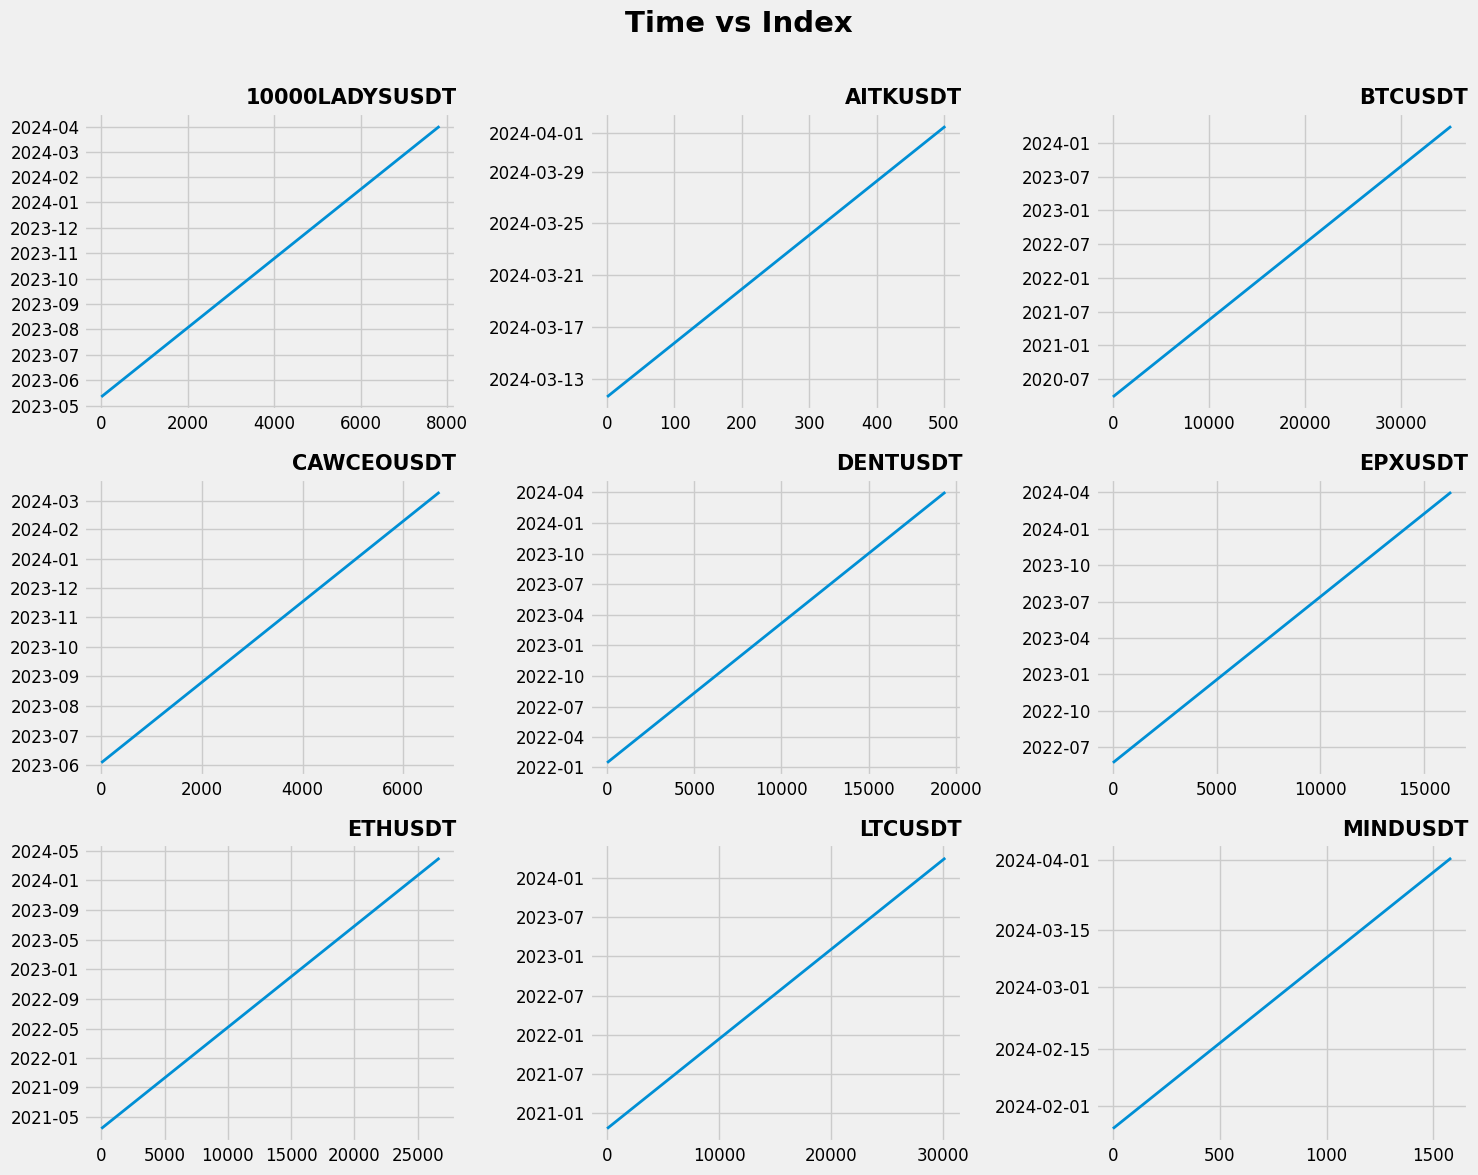

In [5]:
%matplotlib inline

n_cols = 3
n_rows = 3
figsize = (15, 4 * n_rows)

tickers = glob('../optimizer/ticker_dataframes/*_1h.pkl')
random_tickers = random.choices(tickers, k=n_cols*n_rows)
random_tickers[:3] = [t for t in tickers if '/BTCUSDT_1h' in t or '/ETHUSDT_1h' in t or '/LTCUSDT_1h' in t]

def plot_times(random_tickers, n_rows, n_cols):
    fig = plt.figure(figsize=figsize)
    
    for idx in range(n_cols*n_rows):
        ax = plt.subplot(n_rows, n_cols, idx + 1)
        
        df = pd.read_pickle(random_tickers[idx])
        sns.lineplot(data=df['time'])

        ax.set_ylabel('')
        plt.yticks(fontsize=12) 
        ax.set_xlabel('')
        plt.xticks(fontsize=12)
        # ax.spines['right'].set_visible(False)
        ax.set_title(f'{random_tickers[idx].split("/")[-1][:-7]}', loc='right', weight='bold', fontsize=15)
        ax.lines[0].set_linewidth(2)

    
    fig.suptitle(f'Time vs Index\n', ha='center',  fontweight='bold', fontsize=21)
    # fig.legend([1, 0], loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=21, ncol=3)
    plt.tight_layout()
    plt.show()
    
plot_times(sorted(random_tickers),  n_rows=n_rows, n_cols=n_cols) 

### Check if all dataframe files has data for both timeframes 1h and 4h

In [6]:
import glob

x = glob.glob('../optimizer/ticker_dataframes/*.pkl')
y = [i[31:].split('_')[0] for i in x]
z = ('').join(x)

for i in y:
    if f'{i}_1h' not in z:
        print(i, '1h')
    if f'{i}_4h' not in z:
        print(i, '4h')

# Prepare and create train data

### Functions

In [7]:
# Get configs
configs = ConfigFactory.factory(environ).configs

higher_features = ['time', 'linear_reg', 'linear_reg_angle', 'macd', 'macdhist', 'macdsignal']
price_cols = ['open','high', 'low', 'close']
real_price_cols = ['real_high', 'real_low', 'real_close']
funding_cols = ['funding_rate']
rsi_stoch_cols = ['rsi', 'stoch_diff', 'stoch_slowd', 'stoch_slowk']
btcd_cols = ['time', 'btcd_open', 'btcd_high', 'btcd_low', 'btcd_close', 'btcd_volume']
btcdom_cols = ['time', 'btcdom_open', 'btcdom_high', 'btcdom_low', 'btcdom_close', 'btcdom_volume']

def get_file(ticker):
    ''' Find files buy ticker names '''
    try:
        tmp_df_1h = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_1h.pkl')
        tmp_df_4h = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_4h.pkl')
    except FileNotFoundError:
        return None, None
    else:
        return tmp_df_1h, tmp_df_4h

def add_indicators(df, df_higher, ttype, configs):
    # add RSI
    rsi = indicators.RSI(ttype, configs)
    df = rsi.get_indicator(df, '', '', 0)
    # add Stochastic
    stoch = indicators.STOCH(ttype, configs)
    df = stoch.get_indicator(df, '', '', 0)
    # add ATR
    atr = indicators.ATR(ttype, configs)
    df = atr.get_indicator(df, '', '', 0)
    # add CCI
    cci = indicators.CCI(ttype, configs)
    df = cci.get_indicator(df, '', '', 0)
    # add SAR
    sar = indicators.SAR(ttype, configs)
    df = sar.get_indicator(df, '', '', 0)
    # add MACD
    macd = indicators.MACD(ttype, configs)
    df_higher = macd.get_indicator(df_higher, '', '', 0)
    # add Trend
    trend = indicators.Trend(ttype, configs)
    df_higher = trend.get_indicator(df_higher, '', '', 0)
    # merge higher timeframe indicators with working timeframe
    df_higher['time'] = df_higher['time'] + pd.to_timedelta(3, unit='h')
    df[higher_features] = pd.merge(df[['time']], df_higher[higher_features], how='left', on='time')
    df.drop(columns=['close_smooth'], inplace=True)
    df.drop(columns=[c for c in df.columns if c.endswith('_dir')], inplace=True)
    # merge with BTC.D dataframe
    df[btcd_cols] = pd.merge(df[['time']], btcd[btcd_cols], how='left', on='time')
    # merge with BTCDOM dataframe
    df[btcdom_cols] = pd.merge(df[['time']], btcdom[btcdom_cols], how='left', on='time')
    df.ffill(inplace=True)
    df[btcdom_cols] = df[btcdom_cols].fillna(df[btcdom_cols].mean().round(1))
    # price and MACD columns to pct difference
    df[real_price_cols] = df[['high', 'low', 'close']]
    cols_to_scale = ['open', 'high', 'low', 'close', 'macd', 'macdhist', 'macdsignal', 'atr']
    for c in cols_to_scale:
        df[c] = df[c].pct_change() * 100
    # # add aggregate values
    # for col in ['close', 'btcd_close', 'btcdom_close']:
    #     for period in CFG.agg_periods:
    #         for agg_func in CFG.agg_funcs:
    #             df[f'{col}_{agg_func.__name__}_{period}'] = df[col].rolling(period, min_periods=1).agg({'func': agg_func})
    return df.reset_index(drop=True)


def create_train_df(df, ttype, configs, target_offset, first, last, step):
    ''' Create train dataset from signal statistics and ticker candle data'''
    train_df = pd.DataFrame()
    tickers = df['ticker'].unique()
    
    for ticker in tqdm(tickers):
        # get signals with current ticker
        signal_df = df[df['ticker'] == ticker]
        times = signal_df['time']
        
        # load candle history of this ticker
        tmp_df_1h, tmp_df_4h = get_file(ticker)

        # add indicators 
        try:
            tmp_df_1h = add_indicators(tmp_df_1h, tmp_df_4h, ttype, configs)
        except TypeError:
            # print(f'TypeError, ticker - {ticker}')
            continue

        # add historical data for current ticker
        for i, t in enumerate(times.to_list()):
            pass_cycle, sl = False, False
            pattern = signal_df.iloc[i, signal_df.columns.get_loc('pattern')]
            row = tmp_df_1h.loc[tmp_df_1h['time'] == t, :].reset_index(drop=True)
            
            for i in range(first, last + 1, step):
                # collect features every 4 hours, save difference between the current feature and the lagged features
                time_prev = t + timedelta(hours= -i)
                try:
                    row_tmp = tmp_df_1h.loc[tmp_df_1h['time'] == time_prev, [c for c in tmp_df_1h.columns if c not in real_price_cols]].reset_index(drop=True)
                    if i % 8 != 0:
                        row_tmp = row_tmp.drop(columns=funding_cols)
                    if i % 24 != 0:
                        row_tmp = row_tmp.drop(columns=btcd_cols)
                    row_tmp.columns = [c + f'_prev_{i}' for c in row_tmp.columns]
                except IndexError:
                    pass_cycle = True
                    break
                row = pd.concat([row, row_tmp.iloc[:,1:]], axis=1)
                row['ticker'] = ticker
                row['pattern'] = pattern
                
            if pass_cycle:
                continue

            row['target'] = 0
            row['ttype'] = ttype
            
            # If ttype = buy and during the selected period high price was higher than close_price * target_ratio
            # and earlier low price wasn't lower than close_price / target_ratio, than target is True, else target is False.
            # Similarly for ttype = sell 
            if pattern.startswith('MACD'):
                close_price = tmp_df_1h.loc[tmp_df_1h['time'] == t + timedelta(hours=3), 'real_close']
            else:
                close_price = tmp_df_1h.loc[tmp_df_1h['time'] == t, 'real_close']

            # move to the next ticker if can't find any data corresponding to time t
            if close_price.shape[0] == 0:
                break
            
            close_price = close_price.values[0]
            
            for i in range(1, target_offset + 1):
                if pattern.startswith('MACD'):
                    time_next = t + timedelta(hours=3+i)
                else:
                    time_next = t + timedelta(hours=i)
                    
                target_buy = tmp_df_1h.loc[tmp_df_1h['time'] == time_next, 'real_high']
                target_sell = tmp_df_1h.loc[tmp_df_1h['time'] == time_next, 'real_low']
                
                if target_buy.shape[0] == 0 or target_sell.shape[0] == 0:
                    pass_cycle = True
                    break
                
                target_buy = target_buy.values[0]
                target_sell = target_sell.values[0]

                # set 
                higher_price = close_price * CFG.cls_target_ratio_tp
                lower_price = close_price * (2 - CFG.cls_target_ratio_tp)
                target_buy_tp = 1 if target_buy > higher_price else 0
                target_buy_sl = 1 if target_buy > higher_price else 0
                target_sell_tp = 1 if target_sell < lower_price else 0
                target_sell_sl = 1 if target_sell < lower_price else 0

                pattern = row['pattern'].values[0]
                ttype = row['ttype'].values[0]
                
                # set SL flag and exit cycle if price reaches stop-loss threshold before it reaches take-profit threshold
                # (SL depends on ttype and pattern)
                sl1 = pattern.startswith('STOCH') and ttype == 'buy' and target_buy_sl == 1
                sl2 = pattern.startswith('STOCH') and ttype == 'sell' and target_sell_sl == 1

                # set TP flag and exit cycle if price reaches take-profit threshold and doesn't reach stop-loss threshold before
                # (TP depends on ttype and pattern)
                tp1 = pattern.startswith('STOCH') and ttype == 'buy' and target_sell_tp == 1
                tp2 = pattern.startswith('STOCH') and ttype == 'sell' and target_buy_tp == 1
                    
                # if both TP and SL flag is on - don't consider that trade
                if (tp1 and sl1) or (tp2 and sl2):
                    pass_cycle = True
                    break
                elif sl1 or sl2:
                    break
                elif tp1 or tp2:
                    row['target'] = 1
                    break
                
                # if price doesn't reaches both TP and SL thresholds but price above / below enter price for buy / sell trade - set TP flag
                # (depends on ttype and pattern)
                if i == target_offset: 
                    last_price = tmp_df_1h.loc[tmp_df_1h['time'] == time_next, 'real_close'].values[0]
                    l1 = pattern.startswith('STOCH') and ttype == 'buy' and last_price < close_price
                    l2 = pattern.startswith('STOCH') and ttype == 'sell' and last_price > close_price

                    if l1 or l2:
                        row['target'] = 1
            
            if pass_cycle:
                continue
            
            # add data to the dataset
            if train_df.shape[0] == 0:
                train_df = row
            else:
                train_df = pd.concat([train_df, row])
    
    train_df = train_df.drop(columns=real_price_cols)
    return train_df


### Prepare train data

In [8]:
# last previous data point to collect for model training (value represents number of hours before signal point)
last = 272
# for how long time (in hours) we want to predict
target_offset = 96

if CFG.create_dataset:
    # Get BTC dominance
    tv = TvDatafeed(username=tv_username, password=tv_password)
    
    btcd = tv.get_hist('BTC.D','CRYPTOCAP', interval=Interval.in_daily, n_bars=7000, extended_session=True).reset_index()
    btcd = btcd.drop(columns='symbol')
    btcd.columns = btcd_cols
    btcd['time'] = btcd['time'] + pd.to_timedelta(23, unit='h')

    btcdom = tv.get_hist('BTCDOMUSDT.P','BINANCE', interval=Interval.in_4_hour, n_bars=7000, extended_session=True).reset_index()
    btcdom = btcdom.drop(columns='symbol')
    btcdom.columns = btcdom_cols
    btcdom['time'] = btcdom['time'] + pd.to_timedelta(3, unit='h')
    
    # first previous data point to collect for model training (value represents number of hours before signal point)
    first = 4
    # step of previous data points collecting (total number of points to collect is (last - first + step) / step)
    step = 4

    # Buy
    # good hours: 
    # dataset with the signal statistics
    df = pd.read_pickle('signal_stat/buy_stat_1h.pkl')
    df = df[df['time'].dt.year > 1970]
    df = df[df['pattern'].isin(CFG.patterns_to_filter)]
    buy_hours_to_save = [0, 1, 2, 3, 16, 17, 21, 22, 23]
    df = df[df['time'].dt.hour.isin(buy_hours_to_save)]
    # dataset for model train
    train_buy = create_train_df(df, 'buy', configs, target_offset, first, last, step)
    train_buy = train_buy.dropna()
    train_buy.to_pickle(f'signal_stat/train_buy_{last}.pkl')

    display(train_buy.head())
    display(train_buy.shape)

    # Sell
    # good hours 
    # dataset with the signal statistics
    df = pd.read_pickle('signal_stat/sell_stat_1h.pkl')
    df = df[df['time'].dt.year > 1970]
    df = df[df['pattern'].isin(CFG.patterns_to_filter)]
    sell_hours_to_save = [1, 4, 14, 16, 17, 18, 19, 21, 22, 23]
    df = df[df['time'].dt.hour.isin(sell_hours_to_save)]
    # dataset for model train
    train_sell = create_train_df(df, 'sell', configs, target_offset, first, last, step)
    train_sell = train_sell.dropna()
    train_sell.to_pickle(f'signal_stat/train_sell_{last}.pkl')

    # this is made for tests
    df = pd.read_pickle('signal_stat/buy_stat_1h.pkl')
    df = df[df['time'].dt.year > 1970]
    df = df[df['pattern'].isin(CFG.patterns_to_filter)]

    test_df_buy_1 = df[df['time'].dt.hour.isin(buy_hours_to_save[0:1])]
    test_df_buy_1 = create_train_df(test_df_buy_1, 'buy', configs, target_offset, first, last, step)
    test_df_buy_1 = test_df_buy_1.dropna().sort_values('time').reset_index(drop=True)

    df = pd.read_pickle('signal_stat/sell_stat_1h.pkl')
    df = df[df['time'].dt.year > 1970]
    df = df[df['pattern'].isin(CFG.patterns_to_filter)]
    
    test_df_sell_1 = df[df['time'].dt.hour.isin(sell_hours_to_save[0:1])]
    test_df_sell_1 = create_train_df(test_df_sell_1, 'sell', configs, target_offset, first, last, step)
    test_df_sell_1 = test_df_sell_1.dropna().sort_values('time').reset_index(drop=True)

    del df

    display(train_sell.head())
    display(train_sell.shape)

### Create train dataset

In [9]:
train_buy = pd.read_pickle(f'signal_stat/train_buy_{last}.pkl')
train_sell = pd.read_pickle(f'signal_stat/train_sell_{last}.pkl')

train_df = pd.concat([train_buy, train_sell])
train_df = train_df.sort_values('time')

# do not consider the last signals - they may contain erroneus signals
train_df = train_df[train_df['time'] < train_df['time'].max()].reset_index(drop=True)

macd_cols = [c for c in train_df.columns if 'prev' not in c and 'sar' in c]


# Data tests

### Test train dataframe columns

In [10]:
import re

if CFG.create_dataset:
    # check if train dataset has only columns that we expect
    cols = set(re.sub(r'_prev_\d+', '', c) for c in train_buy.columns)

    agg_funcs = ['amin', 'amax', 'mean', 'median', 'std']
    agg_cols = [c for c in cols if len(c.split('_')) > 2 and c.split('_')[-2] in agg_funcs]

    expected_cols = set(price_cols + higher_features + funding_cols + rsi_stoch_cols +
                        btcd_cols + btcdom_cols + agg_cols + ['atr', 'cci', 'sar', 'volume', 'pattern', 'target', 'ticker', 'ttype'])
    assert expected_cols == cols

    # check RSI and STOCH columns, their values must be in [0, 100] range 
    rsi_stoch_cols_ = [c for c in train_df.columns if ('rsi' in c or 'stoch' in c) and 'diff' not in c]
    for r_s_c in rsi_stoch_cols_:
        assert train_df[r_s_c].min() > -0.0001
        assert train_df[r_s_c].max() < 100.0001

    # check volume columns, their values must be >= 0
    vol_cols_ = [c for c in train_df.columns if 'volume' in c]
    for v_c in vol_cols_:
        assert train_df[v_c].min() >= 0

    # check funding columns, their period must be 8 hours
    funding_cols_ = [c for c in train_df.columns if c.startswith('funding')]
    for f_c in funding_cols_:
        num = ''.join([i for i in f_c if i.isdigit()])
        if len(num) > 0:
            num = int(num)
            assert num % 8 == 0

    # check BTC dominance columns, their values must be in [0, 100] range 
    # and their period must be 24 hours
    btcd_cols_ = [c for c in train_df.columns if c.startswith('btcd_') and 'volume' not in c]
    for b_c in btcd_cols_:
        pass_cycle = False
        for a_c in agg_funcs:
            if a_c in b_c:
                pass_cycle = True
                break
        if pass_cycle:
            continue
        # check values
        assert train_df[b_c].min() >= 0
        assert train_df[b_c].max() <= 100
        # check period
        num = ''.join([i for i in b_c if i.isdigit()])
        if len(num) > 0:
            num = int(num)
            assert num % 24 == 0

    # check the rest columns, their period must be 4 hours
    rest_cols_ = [c for c in train_df.columns if c not in funding_cols_ and c not in btcd_cols]
    for r_c in rest_cols_:
        num = ''.join([i for i in r_c if i.isdigit()])
        if len(num) > 0:
            num = int(num)
            assert num % 4 == 0

    # check if changing of source dataframe doesn't affect the resulting train dataframe
    test_df_buy_2 = train_buy[train_buy['time'].dt.hour.isin(buy_hours_to_save[0:1])]
    assert test_df_buy_1.shape == test_df_buy_2.shape
    test_df_sell_2 = train_sell[train_sell['time'].dt.hour.isin(sell_hours_to_save[0:1])]
    assert test_df_sell_1.shape == test_df_sell_2.shape

    # plot time values 
    train_df['time'].plot(title='Signal Time distribution')


### Test buy target corectness

In [11]:
prev_ticker = None

if CFG.create_dataset:
    for i in tqdm(range(train_buy.shape[0])):
        x = train_buy[['ticker', 'ttype', 'pattern', 'time', 'close', 'target']]
        y = x.iloc[i]
        pattern, ticker, time_, target = y['pattern'], y['ticker'], y['time'], y['target']

        if ticker != prev_ticker:
            tmp_df = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_1h.pkl')
            prev_ticker = ticker

        tmp_df_1h = tmp_df.copy()
        idx = tmp_df_1h[tmp_df_1h['time'] == time_].index[0]
        close_price = tmp_df_1h.loc[tmp_df_1h['time'] == time_, 'close'].values[0]
        last_idx = min(idx+target_offset, len(tmp_df_1h)-1)
        last_price = tmp_df_1h.iloc[last_idx, tmp_df_1h.columns.get_loc('close')]
        low_price = close_price * (2 - CFG.cls_target_ratio_tp)
        high_price = close_price * CFG.cls_target_ratio_tp
        tmp_df_1h['low_price'] = low_price
        tmp_df_1h['high_price'] = high_price

        tmp_df_1h = tmp_df_1h.iloc[idx+1:idx+target_offset+1][['time', 'close', 'high', 'high_price', 'low', 'low_price']]
        tmp_df_1h['signal'] = tmp_df_1h['low'] < tmp_df_1h['low_price']
        tmp_df_1h['anti_signal'] = tmp_df_1h['high'] > tmp_df_1h['high_price']
        
        first_signal = tmp_df_1h['signal'].argmax()
        first_anti_signal = tmp_df_1h['anti_signal'].argmax()
        
        if tmp_df_1h['signal'].max() == 0 and tmp_df_1h['anti_signal'].max() == 0:
            if pattern.startswith('STOCH'): 
                if last_price < close_price:
                    assert target == 1
                else:
                    assert target == 0
        elif tmp_df_1h['signal'].max() == 0:
            assert target == 0
        elif tmp_df_1h['anti_signal'].max() == 0:
            assert target == 1
        else:
            if target == 1:
                assert first_signal < first_anti_signal
            else:
                assert first_signal > first_anti_signal

### Test sell target corectness

In [12]:
if CFG.create_dataset:
    for i in tqdm(range(train_sell.shape[0])):
        x = train_sell[['ticker', 'ttype', 'pattern', 'time', 'close', 'target']]
        y = x.iloc[i]
        pattern, ticker, time_, target = y['pattern'], y['ticker'], y['time'], y['target']

        if ticker != prev_ticker:
            tmp_df = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_1h.pkl')
            prev_ticker = ticker

        tmp_df_1h = tmp_df.copy()
        idx = tmp_df_1h[tmp_df_1h['time'] == time_].index[0]
        close_price = tmp_df_1h.loc[tmp_df_1h['time'] == time_, 'close'].values[0]
        last_idx = min(idx+target_offset, len(tmp_df_1h)-1)
        last_price = tmp_df_1h.iloc[last_idx, tmp_df_1h.columns.get_loc('close')]
        low_price = close_price * (2 - CFG.cls_target_ratio_tp)
        high_price = close_price * CFG.cls_target_ratio_tp
        tmp_df_1h['low_price'] = low_price
        tmp_df_1h['high_price'] = high_price

        tmp_df_1h = tmp_df_1h.iloc[idx+1:idx+target_offset+1][['time', 'close', 'high', 'high_price', 'low', 'low_price']]
        tmp_df_1h['signal'] = tmp_df_1h['high'] > tmp_df_1h['high_price']
        tmp_df_1h['anti_signal'] = tmp_df_1h['low'] < tmp_df_1h['low_price']

        first_signal = tmp_df_1h['signal'].argmax()
        first_anti_signal = tmp_df_1h['anti_signal'].argmax()
        
        if tmp_df_1h['signal'].max() == 0 and tmp_df_1h['anti_signal'].max() == 0:
            if pattern.startswith('STOCH'):
                if last_price > close_price:
                    assert target == 1
                else:
                    assert target == 0
        elif tmp_df_1h['signal'].max() == 0:
            assert target == 0
        elif tmp_df_1h['anti_signal'].max() == 0:
            assert target == 1
        else:
            if target == 1:
                assert first_signal < first_anti_signal
            else:
                assert first_signal > first_anti_signal

### Test pattern / target distribution

In [13]:
def trust_interval(row, z=1.95):
    """ Calculate trust interval for Bernulli distribution """
    sum, val1 = row['total'], row['count']
    val2 = sum - val1
    n = val1 + val2
    p = val1 / n
    low_bound = p - z * np.sqrt(p * (1-p) / n)
    high_bound = p + z * np.sqrt(p * (1-p) / n)
    return round(low_bound, 4), round(high_bound, 4)

pvt = train_buy
pvt = pvt[['target', 'pattern', 'time']]
pvt['hour'] = pvt['time'].dt.hour
pvt = pvt.pivot_table(index=['hour', 'target'], values='pattern', aggfunc='count').reset_index()
pvt['total'] = pvt.groupby('hour')['pattern'].transform('sum')
pvt.rename(columns={'pattern': 'count'}, inplace=True)
pvt['pct'] = pvt['count'] / pvt['total']
pvt = pvt[pvt['target']==1]
pvt['trust_interval'] = pvt.apply(trust_interval, axis=1)

print('Buy')
display(pvt)
display(train_buy['ttype'].value_counts())
display(train_buy[['target', 'pattern']].value_counts())
display(train_buy[['target', 'pattern']].value_counts(normalize=True))

pvt = train_sell
pvt = pvt[['target', 'pattern', 'time']]
pvt['hour'] = pvt['time'].dt.hour
pvt = pvt.pivot_table(index=['hour', 'target'], values='pattern', aggfunc='count').reset_index()
pvt['total'] = pvt.groupby('hour')['pattern'].transform('sum')
pvt.rename(columns={'pattern': 'count'}, inplace=True)
pvt['pct'] = pvt['count'] / pvt['total']
pvt = pvt[pvt['target']==1]
pvt['trust_interval'] = pvt.apply(trust_interval, axis=1)

print('Sell')
display(pvt)
display(train_sell['ttype'].value_counts())
display(train_sell[['target', 'pattern']].value_counts())
display(train_sell[['target', 'pattern']].value_counts(normalize=True))

Buy


,hour,target,count,total,pct,trust_interval
1,0,1,846,1472,0.574728,"(0.5496, 0.5999)"
3,1,1,931,1728,0.538773,"(0.5154, 0.5622)"
5,2,1,840,1580,0.531646,"(0.5072, 0.5561)"
7,3,1,962,1846,0.521127,"(0.4985, 0.5438)"
9,16,1,790,1461,0.540726,"(0.5153, 0.5661)"
11,17,1,767,1472,0.521060,"(0.4957, 0.5464)"
13,21,1,824,1518,0.542819,"(0.5179, 0.5678)"
15,22,1,856,1551,0.551902,"(0.5273, 0.5765)"
17,23,1,794,1383,0.574114,"(0.5482, 0.6)"


buy    14011
Name: ttype, dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    7610
0       STOCH_RSI_Volume24    6401
dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    0.543145
0       STOCH_RSI_Volume24    0.456855
dtype: float64

Sell


,hour,target,count,total,pct,trust_interval
1,1,1,518,979,0.529111,"(0.498, 0.5602)"
3,4,1,784,1471,0.532971,"(0.5076, 0.5583)"
5,14,1,766,1458,0.525377,"(0.4999, 0.5509)"
7,16,1,618,1170,0.528205,"(0.4997, 0.5567)"
9,17,1,540,969,0.557276,"(0.5262, 0.5884)"
11,18,1,482,920,0.523913,"(0.4918, 0.556)"
13,19,1,505,940,0.537234,"(0.5055, 0.5689)"
15,21,1,552,1001,0.551449,"(0.5208, 0.5821)"
17,22,1,496,933,0.531618,"(0.4998, 0.5635)"
19,23,1,539,976,0.552254,"(0.5212, 0.5833)"


sell    10817
Name: ttype, dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    5800
0       STOCH_RSI_Volume24    5017
dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    0.536193
0       STOCH_RSI_Volume24    0.463807
dtype: float64

# Data visualization

### Plot ratio of class 1 for every month

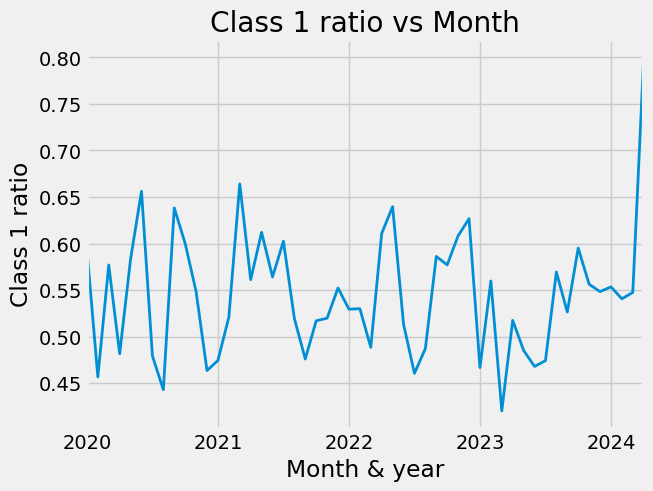

In [14]:
train_df['date_month'] = train_df['time'].dt.to_period('M')
group_df = train_df[train_df['time'].dt.year >= 2020]
ax = group_df.groupby('date_month')['target'].mean().plot()
ax.lines[0].set_linewidth(2)
ax.set_xlabel('Month & year')
ax.set_ylabel('Class 1 ratio')
ax.set_title('Class 1 ratio vs Month')
train_df = train_df.drop(columns='date_month')

### Visualize buy trades

In [15]:
import matplotlib.pyplot as plt
import mplfinance as mpf

if CFG.create_dataset:
    plt_num = 3
    j = 1
    fig = plt.figure(figsize=(30, 6 * plt_num))

    buy_idxs = train_buy.index
    test_buy = train_buy.sample(plt_num, axis=0)

    for i, row in test_buy.iterrows():
        ticker = row['ticker']
        time = row['time']
        target = row['target']
        ttype = row['ttype']
        pattern = row['pattern']

        df_1h, _ = get_file(ticker)
        df_1h = df_1h[(df_1h['time'] >= time) & (df_1h['time'] <= time + timedelta(hours=target_offset))]

        ohlc = df_1h[['time', 'open', 'high', 'low', 'close', 'volume']].set_index('time')
        
        price = df_1h.iloc[0]['close']
        high_price = price * CFG.cls_target_ratio_tp
        low_price = price * (2 - CFG.cls_target_ratio_tp)

        ax = fig.add_subplot(plt_num, 1, j)
        mpf.plot(ohlc, type='candle', warn_too_much_data=1001, style='yahoo', ylabel='', tz_localize=True, ax=ax)
        
        if ttype == 'buy':
            ax.axhline(high_price, color='g')
            ax.axhline(low_price, color='r')
        else:
            ax.axhline(high_price, color='r')
            ax.axhline(low_price, color='g')
        ax.set_title(f'Ticker: {ticker}, price: {price}, pattern {pattern}, target: {target}', fontsize=20)
        j += 1
        
    fig.tight_layout()

### Visualize sell trades

In [16]:
if CFG.create_dataset:
    plt_num = 3
    j = 1
    fig = plt.figure(figsize=(30, 6 * plt_num))

    buy_idxs = train_sell.index
    test_sell = train_sell.sample(plt_num, axis=0)

    for i, row in test_sell.iterrows():
        ticker = row['ticker']
        time = row['time']
        target = row['target']
        ttype = row['ttype']
        pattern = row['pattern']

        df_1h, _ = get_file(ticker)
        df_1h = df_1h[(df_1h['time'] >= time) & (df_1h['time'] <= time + timedelta(hours=target_offset))]
        
        ohlc = df_1h[['time', 'open', 'high', 'low', 'close', 'volume']].set_index('time')
        
        price = df_1h.iloc[0]['close']
        high_price = price * CFG.cls_target_ratio_tp
        low_price = price * (2 - CFG.cls_target_ratio_tp)

        ax = fig.add_subplot(plt_num, 1, j)
        mpf.plot(ohlc, type='candle', warn_too_much_data=1001, style='yahoo', ylabel='', tz_localize=True, ax=ax)
        
        if ttype == 'buy':
            ax.axhline(high_price, color='g')
            ax.axhline(low_price, color='r')
        else:
            ax.axhline(high_price, color='r')
            ax.axhline(low_price, color='g')
        ax.set_title(f'Ticker: {ticker}, price: {price}, pattern {pattern}, target: {target}', fontsize=20)
        j += 1
        
    fig.tight_layout()

### Visualize feature distributions

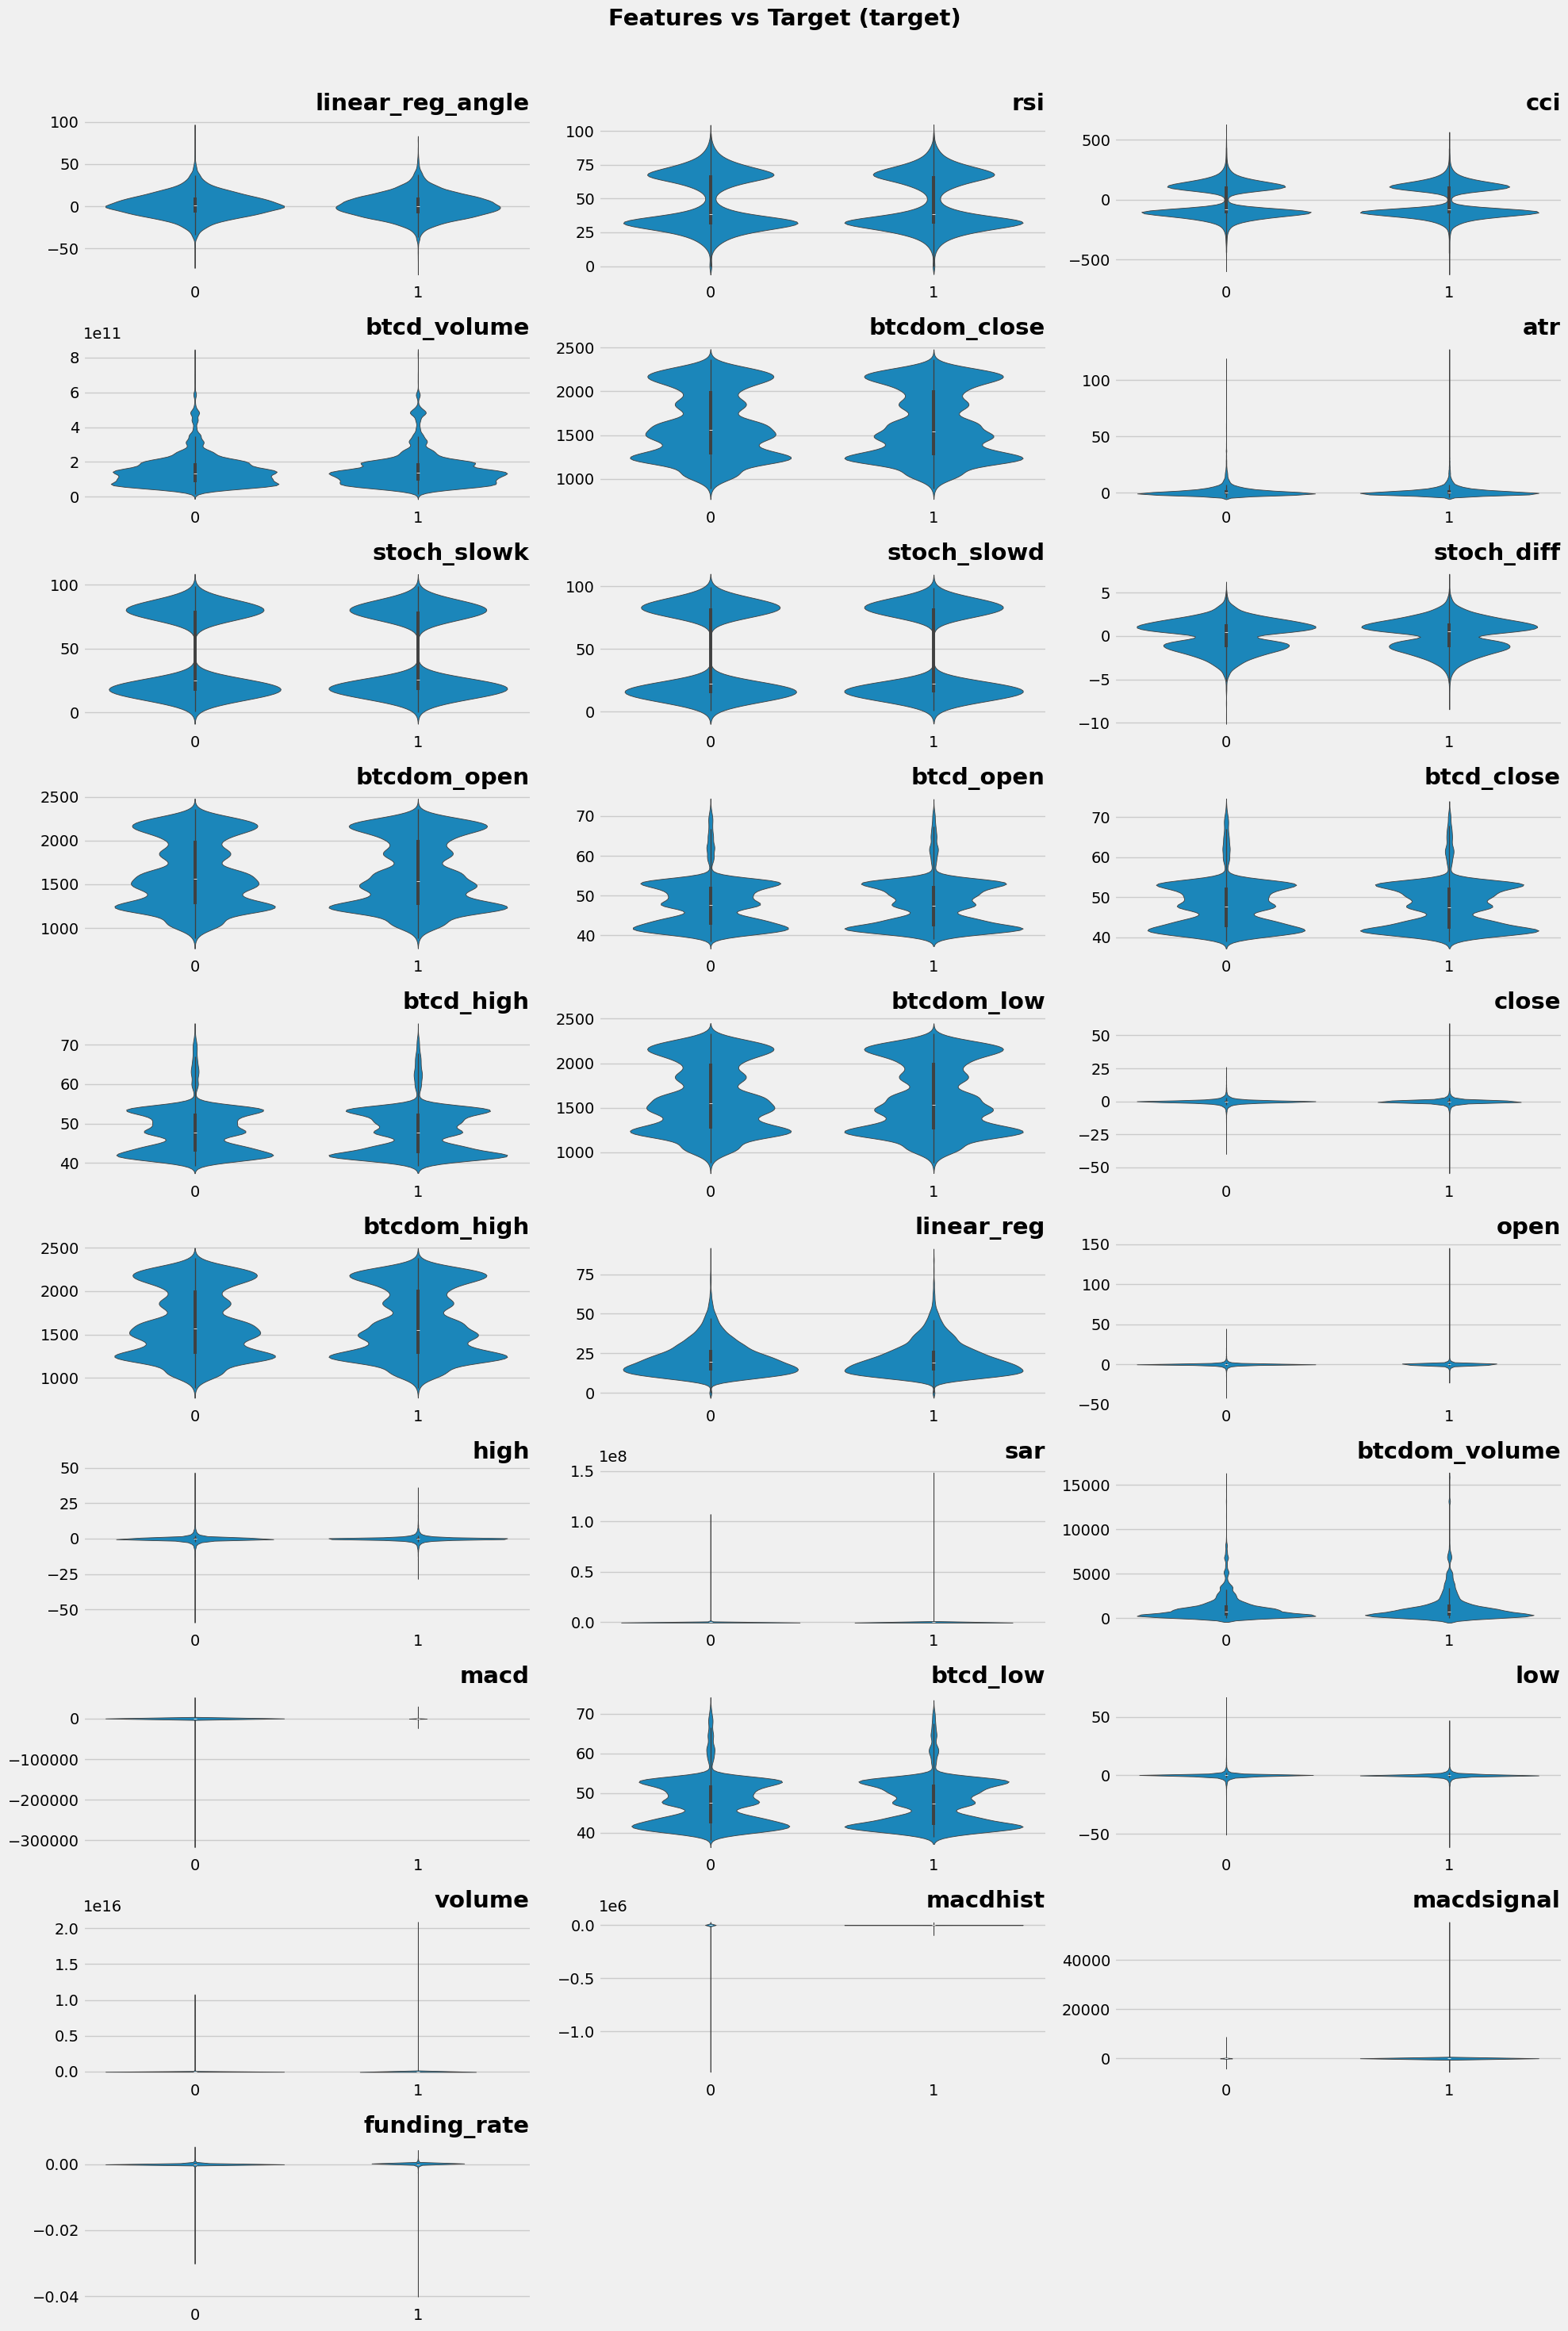

In [17]:
fi = pd.read_csv(f'model/feature_importance.csv')['Feature'].to_list()
cols = [c for c in fi if 'prev' not in c]
figsize = (20, 30)

def plot_target_violine(df, df_cols, n_rows, n_cols, target):
    fig = plt.figure(figsize=figsize)
    
    for idx, col in enumerate(df_cols):
        ax = plt.subplot(n_rows, n_cols, idx + 1)
        try:
            sns.violinplot(x=target, y=col, data=df)
        except ValueError:
            print(f"Can't find {col} in the dataframe")

        ax.set_ylabel(''); ax.spines['top'].set_visible(False), 
        ax.set_xlabel(''); ax.spines['right'].set_visible(False)
        ax.set_title(f'{col}', loc='right', weight='bold', fontsize=21)

    
    fig.suptitle(f'Features vs Target ({target})\n\n\n', ha='center',  fontweight='bold', fontsize=21)
    # fig.legend([1, 0], loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=21, ncol=3)
    plt.tight_layout()
    plt.show()
    
n_cols = 3
n_rows = len(cols) // n_cols + 1
plot_target_violine(train_df, cols, n_rows=n_rows, n_cols=n_cols, target='target')

### Show the last signals

In [18]:
x = pd.read_pickle('signal_stat/buy_stat_1h.pkl')
x['ttype'] = 'buy'
y = pd.read_pickle('signal_stat/sell_stat_1h.pkl')
y['ttype'] = 'sell'
x = pd.concat([x, y]).sort_values('time').reset_index(drop=True)
x.loc[x['pattern'] == 'STOCH_RSI_Volume24', ['time', 'ticker', 'ttype', 'pattern']].tail(35)

,time,ticker,ttype,pattern
79115,2024-04-01 10:00:00,AMBUSDT,buy,STOCH_RSI_Volume24
79116,2024-04-01 10:00:00,ARPAUSDT,buy,STOCH_RSI_Volume24
79117,2024-04-01 10:00:00,CITYUSDT,buy,STOCH_RSI_Volume24
79118,2024-04-01 10:00:00,CTKUSDT,buy,STOCH_RSI_Volume24
79119,2024-04-01 10:00:00,VEXTUSDT,buy,STOCH_RSI_Volume24
79120,2024-04-01 10:00:00,JASMYUSDT,buy,STOCH_RSI_Volume24
79121,2024-04-01 10:00:00,1000FLOKIUSDT,buy,STOCH_RSI_Volume24
79122,2024-04-01 11:00:00,SPELLUSDT,buy,STOCH_RSI_Volume24
79123,2024-04-01 11:00:00,FDUSDUSDT,buy,STOCH_RSI_Volume24
79124,2024-04-01 11:00:00,VCUSDT,sell,STOCH_RSI_Volume24


# Feature selection

### Select features with BORUTA feature importance

In [19]:
from shaphypetune import BoostBoruta
  
params = {
          'boosting_type': 'dart',
          'n_estimators': 1000,
          'learning_rate': 0.02,
          'max_depth': 10,
          'subsample' : 0.7,
          'colsample_bytree': 0.85,
          'num_leaves': 24,
          'verbosity': -1,
          'importance_type': 'gain',
          'max_bin': 255,
          'reg_alpha': 1e-6,
          'reg_lambda': 1e-7,
          'objective': 'binary',
          'metric': 'average_precision'
        }
features = [c for c in train_df.columns if c not in ['time', 'target', 'ticker', 'pattern', 'ttype']]


def boruta_selction(df):
    boruta_df_ = pd.DataFrame()

    X, y, time = df[features], df['target'], df['time']

    tss = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=CFG.n_folds, test_size=len(X) // int(CFG.n_folds * 1.5))
    eval_metric = 'logloss'

    # Stratify based on Class and Alpha (3 types of conditions)
    for fold, (train_idx, val_idx) in enumerate(tss.split(time)):

        print(f'Fold: {fold}')
        # Split the dataset according to the fold indexes.
        X_train = X.iloc[train_idx]
        X_val = X.iloc[val_idx]
        y_train = y.iloc[train_idx]
        y_val = y.iloc[val_idx]

        clf = lgb.LGBMClassifier(**params)
        model = BoostBoruta(clf, importance_type='shap_importances', train_importance=False, max_iter=1000)
        try:
            model.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
                      eval_metric='logloss', 
                      callbacks=[lgb.log_evaluation(100)])
        except RuntimeError:
            break

        boruta_importance_df = pd.DataFrame({'importance': model.ranking_}, index=X_train.columns).sort_index()
        if boruta_df_.shape[0] == 0:
            boruta_df_ = boruta_importance_df.copy()
        else:
            boruta_df_ += boruta_importance_df

    boruta_df_ = boruta_df_.sort_values('importance')
    boruta_df_ = boruta_df_.reset_index().rename({'index': 'Feature'}, axis=1)

    return boruta_df_


if CFG.select_features:
    boruta_df_ = boruta_selction(train_df)

### Select features with permutation importance and GBM feature importance

In [20]:
palette = ['#302c36', '#037d97', '#E4591E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']

blk = Style.BRIGHT + Fore.BLACK
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

def lgbm_tuning(df, permut=False):
    outer_cv_score = [] # store all cv scores of outer loop inference

    perm_df_ = pd.DataFrame()
    feature_importances_ = pd.DataFrame()
    
    for fold in range(CFG.n_repeats):
        print(f'Repeat {blu}#{fold+1}')

        X, y, time = df[features], df['target'], df['time']
        tss = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=CFG.n_folds, test_size=len(X) // int(CFG.n_folds * 1.5))
        eval_metric = 'logloss'
        
        oof = np.zeros(len(df))
        
        # Stratify based on Class and Alpha (3 types of conditions)
        for fold, (train_idx, val_idx) in enumerate(tss.split(time)):
            if fold == 0:
                first_val_idx = val_idx[0]
            
            # Split the dataset according to the fold indexes.
            X_train = X.iloc[train_idx]
            X_val = X.iloc[val_idx]
            y_train = y.iloc[train_idx]
            y_val = y.iloc[val_idx]

            clf = lgb.LGBMClassifier(**params)
            clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
                    eval_metric=eval_metric, 
                    callbacks=[lgb.log_evaluation(100)])

            val_preds = clf.predict_proba(X_val)[:,1]
            val_score = log_loss(y_val, val_preds)
            
            oof[val_idx] = val_preds
            best_iter = clf.best_iteration_

            print(f'Fold: {blu}{fold + 1:>3}{res}| loss: {blu}{val_score:.5f}{res}| Best iteration: {blu}{best_iter:>4}{res}')

            # gboost feature importance
            f_i = pd.DataFrame(sorted(zip(clf.feature_importances_, X.columns), 
                                      reverse=True, key=lambda x: x[1]), 
                                      columns=['Value','Feature'])

            if feature_importances_.shape[0] == 0:
                feature_importances_ = f_i.copy()
            else:
                feature_importances_['Value'] += f_i['Value']
            
            # permutation importance
            if permut:
                perm = PermutationImportance(clf, scoring=None, n_iter=1, 
                                             random_state=42, cv=None, refit=False).fit(X_val, y_val)

                perm_importance_df = pd.DataFrame({'importance': perm.feature_importances_}, 
                                                    index=X_val.columns).sort_index()

                if perm_df_.shape[0] == 0:
                    perm_df_ = perm_importance_df.copy()
                else:
                    perm_df_ += perm_importance_df

        outer_cv = log_loss(y[first_val_idx:], oof[first_val_idx:])
        outer_cv_score.append(outer_cv)

    print(f'{red} Outer Holdout avg score: {res} log_loss: {red}{np.mean(outer_cv_score):.5f}{res}')
    print(f'{"*" * 50}\n')
    
    if permut:
        perm_df_ = perm_df_.sort_values('importance', ascending=False)
        perm_df_ = perm_df_.reset_index().rename({'index': 'Feature'}, axis=1)
                                    
    feature_importances_ = feature_importances_.sort_values('Value', ascending=False).reset_index(drop=True)
    
    return perm_df_, feature_importances_, np.mean(outer_cv_score)


if CFG.select_features:
    perm_df_, feature_importances_, outer_cv_score = lgbm_tuning(train_df, permut=True)

### RFE feature selection

In [21]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

def rfe_selection(df):
    params = {
          'penalty': 'l2',
          'max_iter': 10000,
          'C': 1
        }

    scaler = StandardScaler()
    X, y = df[features], df['target']
    X = scaler.fit_transform(X)
        
    estimator = LogisticRegression(**params)
    selector = RFECV(estimator, min_features_to_select=50, step=0.025, cv=5, verbose=1)
    selector = selector.fit(X, y)
    rfe_df_ = pd.DataFrame({'importance': selector.ranking_}, index=features).sort_index()
    rfe_df_ = rfe_df_.reset_index().rename({'index': 'Feature'}, axis=1)
    return rfe_df_

if CFG.select_features:
    rfe_df_ = rfe_selection(train_df)

### Combine importances and save them

In [22]:
if CFG.select_features:
    boruta_df_['rank'] = boruta_df_['importance'].rank()
    perm_df_['rank'] = perm_df_['importance'].rank(ascending=False)
    rfe_df_['rank'] = rfe_df_['importance']
    feature_importances_['rank'] = feature_importances_['Value'].rank(ascending=False)

    fi = pd.concat([perm_df_[['Feature','rank']], feature_importances_[['Feature','rank']], rfe_df_[['Feature','rank']],
                    boruta_df_[['Feature','rank']]])
    fi = fi.groupby('Feature')['rank'].sum().sort_values().reset_index()
    fi.to_csv(f'model/feature_importance.csv')
else:
    fi = pd.read_csv(f'model/feature_importance.csv')

# Train

### Load selected features

In [23]:
def exclude_corr_features(features, corr_thresh):
    features_to_select = features.copy()
    correlations = train_df.loc[:, features_to_select].corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
    correlations = correlations[correlations['level_0'] != correlations['level_1']] 
    correlations.columns = ['feature_1', 'feature_2', 'corr']

    correlations = pd.merge(left=correlations, right=fi, how='left', left_on='feature_1', right_on='Feature')
    correlations = correlations.drop(columns='Feature')
    correlations = correlations.sort_values(['corr', 'rank'], ascending=[False, True])
    correlations = correlations[::2]

    features_to_exclude = set()
    correlations = correlations[correlations['corr'] > corr_thresh]

    for _, row in correlations.iterrows():
        feature_1 = row['feature_1']
        feature_2 = row['feature_2']

        if feature_1 in features_to_exclude:
            continue

        features_to_exclude.add(feature_2)

    return features_to_exclude


def prepare_features(fi, feature_num, corr_thresh):
    ''' Get features, sort them by their time appearance and return for using in train and inference'''
    # exclude some features 
    fi = fi['Feature']
    fi = fi[:feature_num]
    feature_dict = defaultdict(list)
    features = list()
    
    for f in fi:
        if f == 'volume_24':
            feature_dict[0].append(f)
            continue
        period = f.split('_')
        if period[-1].isdigit() and period[-2] == 'prev':
            feature_dict[int(period[-1])].append('_'.join(period[:-2]))
        else:
            feature_dict[0].append(f)

    feature_dict = dict(sorted(feature_dict.items()))
    
    for item in feature_dict.items():
        if item[0] > 0:
            features.extend([i + f'_prev_{item[0]}' for i in item[1]])
        else:
            features.extend([i for i in item[1]])
    
    # select only features with low correlation
    features_to_exclude = exclude_corr_features(features, corr_thresh)
    features = [f for f in features if f not in features_to_exclude]
    features = list(features) + ['weekday']
    
    # remove highly correlated features from the feature dict
    feature_dict['features'] = features

    for item in feature_dict.items():
        if not isinstance(item[0], int):
            continue

        features_to_remove = list()

        for f in item[1]:
            if item[0] > 0:
                f_ = f'{f}_prev_{item[0]}'
            else:
                f_ = f
            
            if f_ not in features:
                assert f_ in features_to_exclude
                features_to_remove.append(f)
        
        feature_dict[item[0]] = [f for f in feature_dict[item[0]] if f not in features_to_remove]

    # remove empty lists from feature_dict
    empty_list_keys = list()
    
    for key in feature_dict:
        if not feature_dict[key]:
            empty_list_keys.append(key)
            
    for key in empty_list_keys:
        del feature_dict[key]

    return features, feature_dict

feature_num = 94 # 70
corr_thresh = 0.5004052942321255 # 0.701442

train_df['weekday'] = train_df['time'].dt.weekday
fi = pd.read_csv('model/feature_importance.csv')
features, feature_dict = prepare_features(fi, feature_num, corr_thresh)
assert len(features) == len(set(features))

display(features, len(features))

['linear_reg_angle',
 'atr',
 'btcdom_volume_prev_4',
 'btcdom_volume_prev_16',
 'cci_prev_16',
 'stoch_diff_prev_20',
 'high_prev_24',
 'rsi_prev_36',
 'btcdom_volume_prev_44',
 'cci_prev_44',
 'close_prev_48',
 'stoch_diff_prev_52',
 'rsi_prev_52',
 'close_prev_56',
 'rsi_prev_68',
 'btcdom_volume_prev_84',
 'atr_prev_84',
 'cci_prev_88',
 'stoch_diff_prev_88',
 'close_prev_100',
 'high_prev_104',
 'btcdom_volume_prev_116',
 'stoch_diff_prev_124',
 'low_prev_124',
 'cci_prev_136',
 'btcdom_volume_prev_140',
 'low_prev_140',
 'close_prev_144',
 'high_prev_148',
 'close_prev_152',
 'atr_prev_164',
 'open_prev_168',
 'btcdom_volume_prev_172',
 'cci_prev_172',
 'btcdom_volume_prev_188',
 'btcd_volume_prev_192',
 'rsi_prev_208',
 'macdhist_prev_212',
 'close_prev_212',
 'btcdom_volume_prev_216',
 'high_prev_216',
 'open_prev_216',
 'stoch_slowd_prev_220',
 'low_prev_224',
 'btcdom_volume_prev_240',
 'low_prev_248',
 'btcdom_volume_prev_256',
 'btcd_open_prev_264',
 'cci_prev_268',
 'low_p

54

### Functions for train and optimization

In [24]:
val_idxs = list()
prec_score_list = list()
with open(f'model/bybit_tickers.json', 'r') as f:
    bybit_tickers = json.load(f)
df_len = train_df.shape[0]

def confident_score(y, oof, low_bound, high_bound):
    ''' Consider only high confident objects for accuracy and precision scores calculation;
        object probability must be lower than low_bound or higher than high_bound '''
    pred_conf = np.zeros_like(oof)
    pred_conf[oof > high_bound] = 1
    pred_conf_prec = pred_conf[(oof > high_bound)]
    y_conf_prec = y.values.reshape(-1,1)[(oof > high_bound)]
    if y_conf_prec.shape[0] == 0:
        return 0, 0, 0
    return precision_score(y_conf_prec, pred_conf_prec), y_conf_prec.shape[0], y_conf_prec.shape[0]/y.shape[0]

def model_train(df, features, params, n_folds, low_bound, high_bound, train_test, max_train_size=None, verbose=False): 
    X, time = df[features], df['time']
    y = df['target']
    
    if train_test == 'fold':
        oof = np.zeros([len(df), 1])

        tss = TimeSeriesSplit(gap=0, max_train_size=max_train_size, n_splits=n_folds, test_size=(len(df) * 2) // (n_folds * 3))

        if verbose:
            print(f"Training with {len(features)} features")
        
        for fold, (fit_idx, val_idx) in enumerate(tss.split(time)):
            # select only those val_idxs that correspond to 
            # time = max train dataset time + 96 hours to prevent data leakage
            max_time = time[fit_idx].max() + pd.to_timedelta(96, unit='h')
            # also select only tickers from ByBit for validation because we trade on ByBit only
            val_idx = time[(time > max_time) & (df['ticker'].isin(bybit_tickers))].index.tolist()
            
            val_idxs.extend(val_idx)
            
            if verbose:
                print(f'Fold #{fold + 1}')
            
            # Split the dataset according to the fold indexes.
            X_train = X.iloc[fit_idx]
            X_val = X.iloc[val_idx]
            y_train = y.iloc[fit_idx]
            y_val = y.iloc[val_idx]

            if verbose:
                display(y_val.value_counts(normalize=True))
                display(df.loc[val_idx[0], 'time'])
                display(df.loc[val_idx[-1], 'time'])
                callbacks = [lgb.log_evaluation(100)]
            else:
                callbacks = []
            
            model_lgb = lgb.LGBMClassifier(**params)
            model_lgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], 
                          eval_metric='logloss', callbacks=callbacks)

            val_preds = model_lgb.predict_proba(X_val)
        
            val_score = log_loss(y_val, val_preds)
            prec_score, prec_obj_num, prec_obj_pct = confident_score(y_val, val_preds[:, 1], low_bound, high_bound)
            prec_score_list.append(prec_score)
            if verbose:
                print(f'Logloss: {val_score}, Confident objects precision: {prec_score}\n'
                      f'Number of confident objects {prec_obj_num}, % of confident objects: {prec_obj_pct}\n'
                      f'Number of profitable objects: {round((2 * prec_score -  1) * prec_obj_num)}')
            oof[val_idx, 0] = val_preds[:,1]
        
        return oof, model_lgb, sorted(list(set(val_idxs)))
    elif train_test == 'full' or train_test == 'inference':
        print('Train on full data')
        X, y = df[features], df['target']
        
        model_lgb = lgb.LGBMClassifier(**params)
        model_lgb.fit(X, y, eval_set=[(X, y)], eval_metric='logloss', callbacks = [lgb.log_evaluation(100)])
        
        return np.zeros([df.shape[0], 1]), model_lgb, None

def objective(trial):
    params = {
        # Main parameters
#                     'device': 'gpu',
#                     'gpu_platform_id': 0,
#                     'gpu_device_id': 0,
        'objective': 'binary',
        'metric': 'average_precision',
        'boosting_type': trial.suggest_categorical('boosting_type', ['dart', 'goss', 'gbdt']),   
        # Hyperparamters (in order of importance decreasing)
        'n_estimators': trial.suggest_int('n_estimators', 500, 3000),  # max number of trees in model
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 3e-1),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True), # L1,  alias: lambda_l1
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True), # L2, alias: lambda_l2
         # decrease to deal with overfit
        'max_depth': trial.suggest_int('max_depth', 4, 10),   # tree max depth 
         # decrease to deal with overfit
        'num_leaves': trial.suggest_int('num_leaves', 4, 512),  # Max number of leaves in one tree
                                                                # should be ~ 2**(max_depth-1)
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 0.9), # Randomly select a subset of features 
                                                                   # if colsample_bytree < 1.0
                                                                   # alias:feature_fraction
        # increase for accuracy, decrease to deal with overfit
        'max_bin': trial.suggest_int('max_bin', 32, 255), # Max number of bins that feature values will be bucketed in
        # increase to deal with overfit
        'subsample_freq': 1, # Perform bagging at every k iteration, alias: bagging_freq

#           'subsample_for_bin': 200000, # Number of data that sampled to construct feature discrete bins; setting this 
                                     # to larger value will give better training result but may increase train time 
#           'cat_smooth': trial.suggest_float('cat_smooth', 10.0, 100.0),  # this can reduce the effect of noises in 
                                                                       # categorical features, especially for 
                                                                       # categories with few data
        'is_unbalance': trial.suggest_categorical('is_unbalance', [True, False]),                                                   
        'verbose': -1,
        'importance_type': 'gain',
        'high_bound': 0.5,
        'feature_num': trial.suggest_int('feature_num', 50, 500),
        'corr_thresh': trial.suggest_float('corr_thresh', 0.5, 0.99)
    }

    if params['is_unbalance'] is True:
        params['class_weight'] = 'balanced'
    
    if params['boosting_type'] != 'goss':
        params['subsample'] = trial.suggest_float('subsample', 0.3, 0.9)

    high_bound = params['high_bound']
    low_bound = 1 - high_bound
    del params['high_bound']

    corr_thresh = params['corr_thresh']
    del params['corr_thresh']
    
    fi = pd.read_csv(f'model/feature_importance.csv')
    feature_num = params['feature_num']
    del params['feature_num']
    
    train_df['weekday'] = train_df['time'].dt.weekday
    features, _ = prepare_features(fi, feature_num, corr_thresh)
    
    oof, __, val_idxs = model_train(train_df[train_df['time'] < CFG.last_date], features, params, max_train_size=None, 
                                    n_folds=8, low_bound=low_bound, high_bound=high_bound, 
                                    train_test='fold')
    y = train_df['target'][val_idxs]
    oof = oof[val_idxs]
    oof_conf_prec_score, oof_conf_obj_num, oof_conf_obj_pct = confident_score(y, oof, low_bound, high_bound)
    oof_val_score = log_loss(y, oof)
    res = oof_conf_obj_num * (oof_conf_prec_score-0.55) * 100
    # save dataframe with additional information
    df_optuna_more_info = pd.read_csv('optuna/optuna_lgbm_info.csv')
    profit_objects = round(oof_conf_obj_num * (2 * oof_conf_prec_score - 1))
    tmp = pd.DataFrame({'value': [res], 'oof_conf_prec_score': [oof_conf_prec_score], 
                        'profit_objects': [profit_objects], 'oof_val_score': [oof_val_score], 
                        'oof_conf_obj_num': [oof_conf_obj_num], 'oof_conf_obj_pct': [oof_conf_obj_pct], 
                        })
    df_optuna_more_info = pd.concat([df_optuna_more_info, tmp])
    df_optuna_more_info.to_csv('optuna/optuna_lgbm_info.csv', index=False)
    return res

### Train / optimize process

In [25]:
params = {
            'boosting_type': 'gbdt',
            'n_estimators': 1694,
            'learning_rate': 0.005972520918364908,
            'is_unbalance': True,
            'class_weight': 'balanced',
            'colsample_bytree': 0.3722619091228766,
            'subsample': 0.8283912139963654,
            'max_depth': 4,
            'num_leaves': 139,
            'max_bin': 129,
            'reg_alpha': 7.34525126700476e-08,
            'reg_lambda': 0.03738032479600253,
            'subsample_freq': 1,
            'objective': 'binary',
            'importance_type': 'gain',
            'metric': 'average_precision',
            'verbosity': -1
        }

train_test = 'full' # fold, full, inference
max_train_size = None
high_bound = 0.5
low_bound = 1 - high_bound

if CFG.optimize:
    df_optuna_more_info = pd.DataFrame(columns=['value', 'oof_conf_prec_score', 'profit_objects', 
                                                'oof_val_score', 'oof_conf_obj_num', 'oof_conf_obj_pct'])
    df_optuna_more_info.to_csv('optuna/optuna_lgbm_info.csv', index=False)
    
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=1000)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    df_optuna = study.trials_dataframe()
    df_optuna = df_optuna.sort_values('value', ascending=False)
    df_optuna.to_csv(f'optuna/optuna_lgbm.csv')

    display(df_optuna.head(10))
elif train_test == 'fold':
    # fold
    oof, _, val_idxs = model_train(train_df[train_df['time'] < CFG.last_date], features, params, n_folds=8, low_bound=low_bound, high_bound=high_bound, 
                                   train_test=train_test, max_train_size=max_train_size, verbose=True)
    y = train_df['target'][val_idxs]
    oof = oof[val_idxs]
    oof_val_score = log_loss(y, oof)
    oof_conf_prec_score, oof_conf_obj_num, oof_conf_obj_pct = confident_score(y, oof, low_bound, high_bound)

    print(f'Total fold Logloss: {oof_val_score}, Total confident objects precision: {oof_conf_prec_score}\n'
            f'Number of confident objects: {oof_conf_obj_num}, Total % of confident objects: {oof_conf_obj_pct}\n' 
            f'Number of profitable objects: {round(( 2 * oof_conf_prec_score - 1) * oof_conf_obj_num)}')
elif train_test == 'full': 
    oof, model, val_idxs = model_train(train_df[train_df['time'] < CFG.last_date], features, params, n_folds=1, low_bound=low_bound, 
                                       high_bound=high_bound, train_test=train_test, verbose=True)
    joblib.dump(model, f'model/lgbm_full.pkl')
    with open(f'model/features.json', 'w') as f:
        json.dump(feature_dict, f)
elif train_test == 'inference': 
    oof, model, val_idxs = model_train(train_df, features, params, n_folds=1, low_bound=low_bound, 
                                       high_bound=high_bound, train_test=train_test, verbose=True)
    joblib.dump(model, f'model/lgbm.pkl')
    # save feature dictionary for further inference
    with open(f'model/features.json', 'w') as f:
        json.dump(feature_dict, f)

Train on full data
[100]	training's binary_logloss: 0.680066	training's average_precision: 0.680652
[200]	training's binary_logloss: 0.67096	training's average_precision: 0.690673
[300]	training's binary_logloss: 0.664018	training's average_precision: 0.701193
[400]	training's binary_logloss: 0.658176	training's average_precision: 0.71233
[500]	training's binary_logloss: 0.652842	training's average_precision: 0.720637
[600]	training's binary_logloss: 0.64815	training's average_precision: 0.728006
[700]	training's binary_logloss: 0.643835	training's average_precision: 0.735207
[800]	training's binary_logloss: 0.639701	training's average_precision: 0.741929
[900]	training's binary_logloss: 0.635886	training's average_precision: 0.747652
[1000]	training's binary_logloss: 0.632146	training's average_precision: 0.753304
[1100]	training's binary_logloss: 0.628507	training's average_precision: 0.758554
[1200]	training's binary_logloss: 0.625092	training's average_precision: 0.763576
[1300]	tr

In [26]:
# Training with 55 features
# Fold #1
# 1    0.539983
# 0    0.460017
# Name: target, dtype: float64Timestamp('2022-07-04 21:00:00')Timestamp('2024-02-22 23:00:00')
# [100]	training's binary_logloss: 0.667687	training's average_precision: 0.747469	valid_1's binary_logloss: 0.695681	valid_1's average_precision: 0.572836
# [200]	training's binary_logloss: 0.65102	training's average_precision: 0.760489	valid_1's binary_logloss: 0.698015	valid_1's average_precision: 0.57503
# [300]	training's binary_logloss: 0.638747	training's average_precision: 0.774041	valid_1's binary_logloss: 0.697536	valid_1's average_precision: 0.577534
# [400]	training's binary_logloss: 0.628268	training's average_precision: 0.786511	valid_1's binary_logloss: 0.697048	valid_1's average_precision: 0.580631
# [500]	training's binary_logloss: 0.618712	training's average_precision: 0.797551	valid_1's binary_logloss: 0.696343	valid_1's average_precision: 0.579965
# [600]	training's binary_logloss: 0.609469	training's average_precision: 0.807956	valid_1's binary_logloss: 0.69512	valid_1's average_precision: 0.580882
# [700]	training's binary_logloss: 0.60096	training's average_precision: 0.818083	valid_1's binary_logloss: 0.694687	valid_1's average_precision: 0.58068
# [800]	training's binary_logloss: 0.592903	training's average_precision: 0.828149	valid_1's binary_logloss: 0.693944	valid_1's average_precision: 0.580154
# [900]	training's binary_logloss: 0.585115	training's average_precision: 0.836184	valid_1's binary_logloss: 0.694038	valid_1's average_precision: 0.579034
# [1000]	training's binary_logloss: 0.57806	training's average_precision: 0.843946	valid_1's binary_logloss: 0.693912	valid_1's average_precision: 0.578702
# [1100]	training's binary_logloss: 0.57119	training's average_precision: 0.850819	valid_1's binary_logloss: 0.693656	valid_1's average_precision: 0.578619
# [1200]	training's binary_logloss: 0.564261	training's average_precision: 0.858092	valid_1's binary_logloss: 0.693983	valid_1's average_precision: 0.576793
# [1300]	training's binary_logloss: 0.557929	training's average_precision: 0.864384	valid_1's binary_logloss: 0.694114	valid_1's average_precision: 0.57684
# [1400]	training's binary_logloss: 0.551639	training's average_precision: 0.87058	valid_1's binary_logloss: 0.694219	valid_1's average_precision: 0.576829
# [1500]	training's binary_logloss: 0.545649	training's average_precision: 0.876312	valid_1's binary_logloss: 0.694521	valid_1's average_precision: 0.576014
# [1600]	training's binary_logloss: 0.539813	training's average_precision: 0.881603	valid_1's binary_logloss: 0.694858	valid_1's average_precision: 0.57578
# Logloss: 0.6953187453581172, Confident objects precision: 0.571590909090909
# Number of confident objects 4400, % of confident objects: 0.5438141144481523
# Number of profitable objects: 630
# Fold #2
# 1    0.541389
# 0    0.458611
# Name: target, dtype: float64Timestamp('2022-09-23 04:00:00')Timestamp('2024-02-22 23:00:00')
# [100]	training's binary_logloss: 0.669856	training's average_precision: 0.729791	valid_1's binary_logloss: 0.692626	valid_1's average_precision: 0.590017
# [200]	training's binary_logloss: 0.653828	training's average_precision: 0.743836	valid_1's binary_logloss: 0.691755	valid_1's average_precision: 0.593348
# [300]	training's binary_logloss: 0.641629	training's average_precision: 0.757282	valid_1's binary_logloss: 0.689852	valid_1's average_precision: 0.595319
# [400]	training's binary_logloss: 0.631359	training's average_precision: 0.769357	valid_1's binary_logloss: 0.688846	valid_1's average_precision: 0.594055
# [500]	training's binary_logloss: 0.622466	training's average_precision: 0.780408	valid_1's binary_logloss: 0.687893	valid_1's average_precision: 0.595218
# [600]	training's binary_logloss: 0.614104	training's average_precision: 0.790268	valid_1's binary_logloss: 0.687637	valid_1's average_precision: 0.59374
# [700]	training's binary_logloss: 0.606837	training's average_precision: 0.798581	valid_1's binary_logloss: 0.687519	valid_1's average_precision: 0.592551
# [800]	training's binary_logloss: 0.599819	training's average_precision: 0.806529	valid_1's binary_logloss: 0.687517	valid_1's average_precision: 0.590177
# [900]	training's binary_logloss: 0.592963	training's average_precision: 0.814261	valid_1's binary_logloss: 0.687568	valid_1's average_precision: 0.59056
# [1000]	training's binary_logloss: 0.586693	training's average_precision: 0.821241	valid_1's binary_logloss: 0.688057	valid_1's average_precision: 0.58859
# [1100]	training's binary_logloss: 0.580338	training's average_precision: 0.828573	valid_1's binary_logloss: 0.688087	valid_1's average_precision: 0.587778
# [1200]	training's binary_logloss: 0.574378	training's average_precision: 0.83518	valid_1's binary_logloss: 0.68842	valid_1's average_precision: 0.586989
# [1300]	training's binary_logloss: 0.568681	training's average_precision: 0.841494	valid_1's binary_logloss: 0.688772	valid_1's average_precision: 0.58586
# [1400]	training's binary_logloss: 0.563592	training's average_precision: 0.846551	valid_1's binary_logloss: 0.689156	valid_1's average_precision: 0.585255
# [1500]	training's binary_logloss: 0.558447	training's average_precision: 0.852044	valid_1's binary_logloss: 0.689498	valid_1's average_precision: 0.585025
# [1600]	training's binary_logloss: 0.553206	training's average_precision: 0.857481	valid_1's binary_logloss: 0.689786	valid_1's average_precision: 0.584415
# Logloss: 0.6903921572347769, Confident objects precision: 0.5627977479428324
# Number of confident objects 4618, % of confident objects: 0.6556864972312935
# Number of profitable objects: 580
# Fold #3
# 1    0.534068
# 0    0.465932
# Name: target, dtype: float64Timestamp('2023-01-18 22:00:00')Timestamp('2024-02-22 23:00:00')
# [100]	training's binary_logloss: 0.672267	training's average_precision: 0.720812	valid_1's binary_logloss: 0.691964	valid_1's average_precision: 0.563853
# [200]	training's binary_logloss: 0.65814	training's average_precision: 0.736331	valid_1's binary_logloss: 0.691164	valid_1's average_precision: 0.570164
# [300]	training's binary_logloss: 0.64705	training's average_precision: 0.748956	valid_1's binary_logloss: 0.689929	valid_1's average_precision: 0.57613
# [400]	training's binary_logloss: 0.638004	training's average_precision: 0.760767	valid_1's binary_logloss: 0.68986	valid_1's average_precision: 0.575237
# [500]	training's binary_logloss: 0.629837	training's average_precision: 0.770899	valid_1's binary_logloss: 0.689464	valid_1's average_precision: 0.577746
# [600]	training's binary_logloss: 0.622234	training's average_precision: 0.780117	valid_1's binary_logloss: 0.689366	valid_1's average_precision: 0.577357
# [700]	training's binary_logloss: 0.615406	training's average_precision: 0.788348	valid_1's binary_logloss: 0.68963	valid_1's average_precision: 0.575925
# [800]	training's binary_logloss: 0.608847	training's average_precision: 0.796178	valid_1's binary_logloss: 0.689403	valid_1's average_precision: 0.578058
# [900]	training's binary_logloss: 0.602645	training's average_precision: 0.803451	valid_1's binary_logloss: 0.689796	valid_1's average_precision: 0.577907
# [1000]	training's binary_logloss: 0.596767	training's average_precision: 0.80979	valid_1's binary_logloss: 0.689677	valid_1's average_precision: 0.578908
# [1100]	training's binary_logloss: 0.59121	training's average_precision: 0.815769	valid_1's binary_logloss: 0.689597	valid_1's average_precision: 0.578377
# [1200]	training's binary_logloss: 0.585932	training's average_precision: 0.821918	valid_1's binary_logloss: 0.689233	valid_1's average_precision: 0.579553
# [1300]	training's binary_logloss: 0.580919	training's average_precision: 0.82735	valid_1's binary_logloss: 0.689	valid_1's average_precision: 0.579994
# [1400]	training's binary_logloss: 0.575835	training's average_precision: 0.833222	valid_1's binary_logloss: 0.688741	valid_1's average_precision: 0.580763
# [1500]	training's binary_logloss: 0.571059	training's average_precision: 0.838739	valid_1's binary_logloss: 0.688811	valid_1's average_precision: 0.580761
# [1600]	training's binary_logloss: 0.566312	training's average_precision: 0.843694	valid_1's binary_logloss: 0.689022	valid_1's average_precision: 0.580286
# Logloss: 0.688737265101105, Confident objects precision: 0.5717970765262252
# Number of confident objects 3489, % of confident objects: 0.5742264647794602
# Number of profitable objects: 501
# Fold #4
# 1    0.543363
# 0    0.456637
# Name: target, dtype: float64Timestamp('2023-04-09 16:00:00')Timestamp('2024-02-22 23:00:00')
# [100]	training's binary_logloss: 0.673948	training's average_precision: 0.713566	valid_1's binary_logloss: 0.691677	valid_1's average_precision: 0.584617
# [200]	training's binary_logloss: 0.660297	training's average_precision: 0.729208	valid_1's binary_logloss: 0.690937	valid_1's average_precision: 0.586638
# [300]	training's binary_logloss: 0.649794	training's average_precision: 0.741038	valid_1's binary_logloss: 0.689731	valid_1's average_precision: 0.588114
# [400]	training's binary_logloss: 0.641418	training's average_precision: 0.752114	valid_1's binary_logloss: 0.688811	valid_1's average_precision: 0.589765
# [500]	training's binary_logloss: 0.634042	training's average_precision: 0.761396	valid_1's binary_logloss: 0.687278	valid_1's average_precision: 0.59216
# [600]	training's binary_logloss: 0.627271	training's average_precision: 0.769475	valid_1's binary_logloss: 0.686525	valid_1's average_precision: 0.593533
# [700]	training's binary_logloss: 0.620945	training's average_precision: 0.77802	valid_1's binary_logloss: 0.685706	valid_1's average_precision: 0.59378
# [800]	training's binary_logloss: 0.614905	training's average_precision: 0.785545	valid_1's binary_logloss: 0.685325	valid_1's average_precision: 0.591506
# [900]	training's binary_logloss: 0.609241	training's average_precision: 0.792297	valid_1's binary_logloss: 0.685176	valid_1's average_precision: 0.590679
# [1000]	training's binary_logloss: 0.604133	training's average_precision: 0.798194	valid_1's binary_logloss: 0.684967	valid_1's average_precision: 0.592262
# [1100]	training's binary_logloss: 0.599039	training's average_precision: 0.804204	valid_1's binary_logloss: 0.685176	valid_1's average_precision: 0.591553
# [1200]	training's binary_logloss: 0.594191	training's average_precision: 0.809781	valid_1's binary_logloss: 0.685035	valid_1's average_precision: 0.593631
# [1300]	training's binary_logloss: 0.589505	training's average_precision: 0.815031	valid_1's binary_logloss: 0.685106	valid_1's average_precision: 0.593955
# [1400]	training's binary_logloss: 0.584881	training's average_precision: 0.820792	valid_1's binary_logloss: 0.685797	valid_1's average_precision: 0.592283
# [1500]	training's binary_logloss: 0.580534	training's average_precision: 0.826119	valid_1's binary_logloss: 0.686486	valid_1's average_precision: 0.591268
# [1600]	training's binary_logloss: 0.576123	training's average_precision: 0.831348	valid_1's binary_logloss: 0.687294	valid_1's average_precision: 0.589465
# Logloss: 0.6876080571910481, Confident objects precision: 0.577927548441449
# Number of confident objects 3561, % of confident objects: 0.7249592833876222
# Number of profitable objects: 555
# Fold #5
# 1    0.561665
# 0    0.438335
# Name: target, dtype: float64Timestamp('2023-06-12 22:00:00')Timestamp('2024-02-22 23:00:00')
# [100]	training's binary_logloss: 0.674144	training's average_precision: 0.71663	valid_1's binary_logloss: 0.698273	valid_1's average_precision: 0.619089
# [200]	training's binary_logloss: 0.660543	training's average_precision: 0.730172	valid_1's binary_logloss: 0.7003	valid_1's average_precision: 0.625187
# [300]	training's binary_logloss: 0.650071	training's average_precision: 0.741479	valid_1's binary_logloss: 0.70032	valid_1's average_precision: 0.622985
# [400]	training's binary_logloss: 0.641741	training's average_precision: 0.751353	valid_1's binary_logloss: 0.69778	valid_1's average_precision: 0.622086
# [500]	training's binary_logloss: 0.634353	training's average_precision: 0.760298	valid_1's binary_logloss: 0.695012	valid_1's average_precision: 0.621829
# [600]	training's binary_logloss: 0.62763	training's average_precision: 0.767897	valid_1's binary_logloss: 0.693886	valid_1's average_precision: 0.622118
# [700]	training's binary_logloss: 0.621728	training's average_precision: 0.775211	valid_1's binary_logloss: 0.692951	valid_1's average_precision: 0.622238
# [800]	training's binary_logloss: 0.616221	training's average_precision: 0.781477	valid_1's binary_logloss: 0.691079	valid_1's average_precision: 0.62226
# [900]	training's binary_logloss: 0.610944	training's average_precision: 0.787625	valid_1's binary_logloss: 0.690072	valid_1's average_precision: 0.620815
# [1000]	training's binary_logloss: 0.606104	training's average_precision: 0.792769	valid_1's binary_logloss: 0.68895	valid_1's average_precision: 0.620831
# [1100]	training's binary_logloss: 0.601412	training's average_precision: 0.798318	valid_1's binary_logloss: 0.68868	valid_1's average_precision: 0.620981
# [1200]	training's binary_logloss: 0.596952	training's average_precision: 0.803696	valid_1's binary_logloss: 0.688645	valid_1's average_precision: 0.620768
# [1300]	training's binary_logloss: 0.592671	training's average_precision: 0.808409	valid_1's binary_logloss: 0.687493	valid_1's average_precision: 0.621673
# [1400]	training's binary_logloss: 0.588434	training's average_precision: 0.813495	valid_1's binary_logloss: 0.686891	valid_1's average_precision: 0.622584
# [1500]	training's binary_logloss: 0.584365	training's average_precision: 0.818492	valid_1's binary_logloss: 0.686768	valid_1's average_precision: 0.621722
# [1600]	training's binary_logloss: 0.580276	training's average_precision: 0.822633	valid_1's binary_logloss: 0.686901	valid_1's average_precision: 0.62126
# Logloss: 0.6862429492958183, Confident objects precision: 0.6157813305827746
# Number of confident objects 1939, % of confident objects: 0.5077245352186436
# Number of profitable objects: 449
# Fold #6
# 1    0.573286
# 0    0.426714
# Name: target, dtype: float64Timestamp('2023-09-01 02:00:00')Timestamp('2024-02-22 23:00:00')
# [100]	training's binary_logloss: 0.676049	training's average_precision: 0.710766	valid_1's binary_logloss: 0.693857	valid_1's average_precision: 0.603209
# [200]	training's binary_logloss: 0.663818	training's average_precision: 0.723598	valid_1's binary_logloss: 0.694845	valid_1's average_precision: 0.602356
# [300]	training's binary_logloss: 0.654404	training's average_precision: 0.733428	valid_1's binary_logloss: 0.695634	valid_1's average_precision: 0.60108
# [400]	training's binary_logloss: 0.646853	training's average_precision: 0.742025	valid_1's binary_logloss: 0.695445	valid_1's average_precision: 0.60273
# [500]	training's binary_logloss: 0.63997	training's average_precision: 0.750758	valid_1's binary_logloss: 0.695952	valid_1's average_precision: 0.603728
# [600]	training's binary_logloss: 0.633884	training's average_precision: 0.757404	valid_1's binary_logloss: 0.69561	valid_1's average_precision: 0.607383
# [700]	training's binary_logloss: 0.628386	training's average_precision: 0.764498	valid_1's binary_logloss: 0.695145	valid_1's average_precision: 0.608058
# [800]	training's binary_logloss: 0.623027	training's average_precision: 0.771218	valid_1's binary_logloss: 0.694537	valid_1's average_precision: 0.611168
# [900]	training's binary_logloss: 0.618291	training's average_precision: 0.776888	valid_1's binary_logloss: 0.694754	valid_1's average_precision: 0.611712
# [1000]	training's binary_logloss: 0.613799	training's average_precision: 0.782391	valid_1's binary_logloss: 0.694549	valid_1's average_precision: 0.611476
# [1100]	training's binary_logloss: 0.609296	training's average_precision: 0.787744	valid_1's binary_logloss: 0.694453	valid_1's average_precision: 0.611379
# [1200]	training's binary_logloss: 0.604973	training's average_precision: 0.793197	valid_1's binary_logloss: 0.694679	valid_1's average_precision: 0.611421
# [1300]	training's binary_logloss: 0.60094	training's average_precision: 0.797603	valid_1's binary_logloss: 0.694732	valid_1's average_precision: 0.612841
# [1400]	training's binary_logloss: 0.596982	training's average_precision: 0.802338	valid_1's binary_logloss: 0.694769	valid_1's average_precision: 0.61316
# [1500]	training's binary_logloss: 0.593178	training's average_precision: 0.807076	valid_1's binary_logloss: 0.695177	valid_1's average_precision: 0.612732
# [1600]	training's binary_logloss: 0.589482	training's average_precision: 0.811297	valid_1's binary_logloss: 0.695627	valid_1's average_precision: 0.61266
# Logloss: 0.6961025691320956, Confident objects precision: 0.6048442906574395
# Number of confident objects 1445, % of confident objects: 0.507908611599297
# Number of profitable objects: 303
# Fold #7
# 1    0.560067
# 0    0.439933
# Name: target, dtype: float64Timestamp('2023-11-15 14:00:00')Timestamp('2024-02-22 23:00:00')
# [100]	training's binary_logloss: 0.677741	training's average_precision: 0.702927	valid_1's binary_logloss: 0.693975	valid_1's average_precision: 0.584538
# [200]	training's binary_logloss: 0.666872	training's average_precision: 0.713874	valid_1's binary_logloss: 0.694031	valid_1's average_precision: 0.588414
# [300]	training's binary_logloss: 0.658688	training's average_precision: 0.723284	valid_1's binary_logloss: 0.693546	valid_1's average_precision: 0.593104
# [400]	training's binary_logloss: 0.652046	training's average_precision: 0.732077	valid_1's binary_logloss: 0.693165	valid_1's average_precision: 0.598111
# [500]	training's binary_logloss: 0.646185	training's average_precision: 0.740166	valid_1's binary_logloss: 0.693502	valid_1's average_precision: 0.591796
# [600]	training's binary_logloss: 0.640535	training's average_precision: 0.747456	valid_1's binary_logloss: 0.693542	valid_1's average_precision: 0.59236
# [700]	training's binary_logloss: 0.635638	training's average_precision: 0.754767	valid_1's binary_logloss: 0.693834	valid_1's average_precision: 0.590445
# [800]	training's binary_logloss: 0.630906	training's average_precision: 0.761237	valid_1's binary_logloss: 0.693531	valid_1's average_precision: 0.591306
# [900]	training's binary_logloss: 0.626343	training's average_precision: 0.767356	valid_1's binary_logloss: 0.69359	valid_1's average_precision: 0.593079
# [1000]	training's binary_logloss: 0.622315	training's average_precision: 0.772055	valid_1's binary_logloss: 0.693836	valid_1's average_precision: 0.592955
# [1100]	training's binary_logloss: 0.618445	training's average_precision: 0.777505	valid_1's binary_logloss: 0.694296	valid_1's average_precision: 0.592131
# [1200]	training's binary_logloss: 0.61467	training's average_precision: 0.782977	valid_1's binary_logloss: 0.694627	valid_1's average_precision: 0.590213
# [1300]	training's binary_logloss: 0.610823	training's average_precision: 0.787395	valid_1's binary_logloss: 0.694153	valid_1's average_precision: 0.591544
# [1400]	training's binary_logloss: 0.607341	training's average_precision: 0.791879	valid_1's binary_logloss: 0.694292	valid_1's average_precision: 0.590767
# [1500]	training's binary_logloss: 0.603874	training's average_precision: 0.796518	valid_1's binary_logloss: 0.694632	valid_1's average_precision: 0.589911
# [1600]	training's binary_logloss: 0.60027	training's average_precision: 0.800973	valid_1's binary_logloss: 0.694932	valid_1's average_precision: 0.58974
# Logloss: 0.6954220690783265, Confident objects precision: 0.6007067137809188
# Number of confident objects 849, % of confident objects: 0.4721913236929922
# Number of profitable objects: 171
# Fold #8
# 1    0.567095
# 0    0.432905
# Name: target, dtype: float64Timestamp('2024-01-12 01:00:00')Timestamp('2024-02-22 23:00:00')
# [100]	training's binary_logloss: 0.679487	training's average_precision: 0.692714	valid_1's binary_logloss: 0.693932	valid_1's average_precision: 0.631662
# [200]	training's binary_logloss: 0.669613	training's average_precision: 0.702841	valid_1's binary_logloss: 0.692925	valid_1's average_precision: 0.638758
# [300]	training's binary_logloss: 0.662202	training's average_precision: 0.712434	valid_1's binary_logloss: 0.692585	valid_1's average_precision: 0.631701
# [400]	training's binary_logloss: 0.656221	training's average_precision: 0.721338	valid_1's binary_logloss: 0.691366	valid_1's average_precision: 0.637396
# [500]	training's binary_logloss: 0.650625	training's average_precision: 0.730032	valid_1's binary_logloss: 0.6912	valid_1's average_precision: 0.640081
# [600]	training's binary_logloss: 0.645494	training's average_precision: 0.73768	valid_1's binary_logloss: 0.690607	valid_1's average_precision: 0.642852
# [700]	training's binary_logloss: 0.641058	training's average_precision: 0.744737	valid_1's binary_logloss: 0.69016	valid_1's average_precision: 0.645146
# [800]	training's binary_logloss: 0.636711	training's average_precision: 0.751546	valid_1's binary_logloss: 0.690319	valid_1's average_precision: 0.645112
# [900]	training's binary_logloss: 0.632789	training's average_precision: 0.757291	valid_1's binary_logloss: 0.690633	valid_1's average_precision: 0.64374
# [1000]	training's binary_logloss: 0.628884	training's average_precision: 0.762507	valid_1's binary_logloss: 0.690751	valid_1's average_precision: 0.642674
# [1100]	training's binary_logloss: 0.625123	training's average_precision: 0.767727	valid_1's binary_logloss: 0.690341	valid_1's average_precision: 0.644563
# [1200]	training's binary_logloss: 0.621506	training's average_precision: 0.772797	valid_1's binary_logloss: 0.690857	valid_1's average_precision: 0.640125
# [1300]	training's binary_logloss: 0.617936	training's average_precision: 0.777283	valid_1's binary_logloss: 0.690395	valid_1's average_precision: 0.640841
# [1400]	training's binary_logloss: 0.614633	training's average_precision: 0.781959	valid_1's binary_logloss: 0.691107	valid_1's average_precision: 0.639849
# [1500]	training's binary_logloss: 0.611376	training's average_precision: 0.786601	valid_1's binary_logloss: 0.691384	valid_1's average_precision: 0.63855
# [1600]	training's binary_logloss: 0.608113	training's average_precision: 0.791123	valid_1's binary_logloss: 0.692087	valid_1's average_precision: 0.637451
# Logloss: 0.6919758376648109, Confident objects precision: 0.6340057636887608
# Number of confident objects 347, % of confident objects: 0.4049008168028005
# Number of profitable objects: 93
# Total fold Logloss: 0.6931170677148534, Total confident objects precision: 0.6119585112873703
# Number of confident objects: 3278, Total % of confident objects: 0.40514151526387343
# Number of profitable objects: 734

### Visualize train results

In [27]:
if not CFG.optimize and train_test == 'fold':
    sns.lineplot(x=list(range(1, 9)), y=prec_score_list)

    plt.title('Model precision score by folds')
    plt.xlabel('Folds')
    plt.xticks(fontsize=12)
    plt.ylabel('Precision score')
    plt.yticks(fontsize=12)

    plt.show()

### Distribution of model prediction scores

In [28]:
if not CFG.optimize and train_test == 'fold':
    sns.displot(oof)

    plt.xlabel('Model prediction scores')
    plt.xticks(fontsize=10)
    plt.ylabel('Number of predictions')
    plt.yticks(fontsize=10)

# Test model

### Test model predictions on the new data

In [29]:
if not CFG.optimize and train_test == 'full':
    if train_test == 'test':
        model = joblib.load('model/lgbm_full.pkl')

    with open(f'model/bybit_tickers.json', 'r') as f:
        bybit_tickers = json.load(f)

    X = train_df[(train_df['ticker'].isin(bybit_tickers))]
    X['pred'] = model.predict_proba(X[features])[:,1]
    res = X.loc[(X['pred'] >= high_bound) & (X['time'] >= CFG.last_date), ['time', 'ticker', 'ttype', 'pred', 'target', 'pattern']]
    display(res['time'].min(), res['time'].max())
    display(res['target'].value_counts())
    display(res['target'].value_counts(normalize=True))

Timestamp('2024-03-01 02:00:00')

Timestamp('2024-04-01 01:00:00')

1    262
0    162
Name: target, dtype: int64

1    0.617925
0    0.382075
Name: target, dtype: float64

### Plot the mean precision of the model predictions on the new data

In [30]:
# Timestamp('2024-03-01 02:00:00')
# Timestamp('2024-04-01 01:00:00')

# 1    262
# 0    162

# 1    0.617925
# 0    0.382075


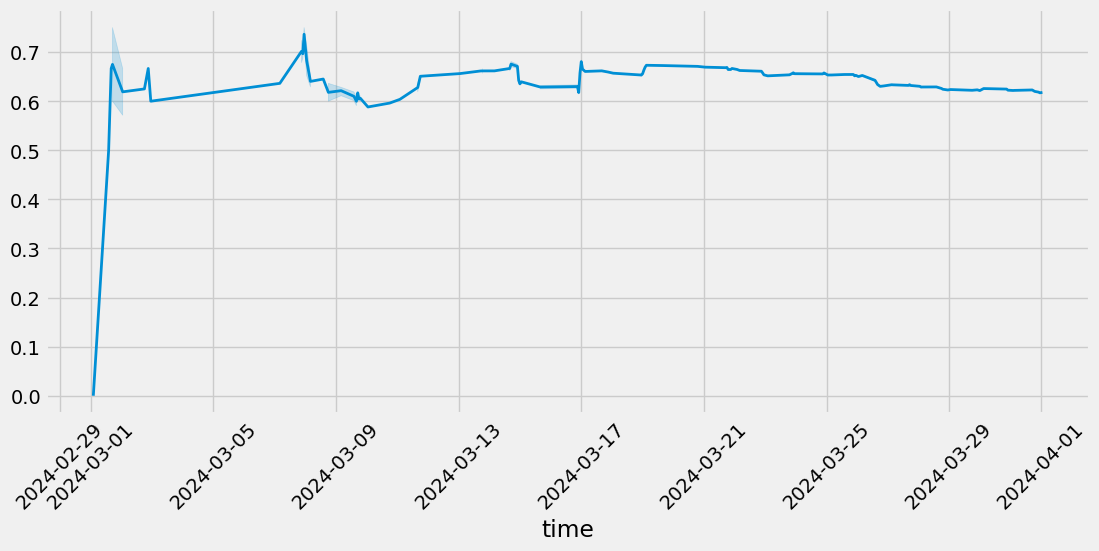

In [31]:
if not CFG.optimize and train_test == 'full':
    figsize = (12, 5)
    plt.figure(figsize=figsize)

    res['mean_precision'] = res['target'].rolling(len(res), min_periods=1).mean()

    ax = sns.lineplot(x=res['time'], y=res['mean_precision'].values)
    ax.lines[0].set_linewidth(2)
    plt.xticks(rotation=45);

### Display PR curve

In [32]:
from sklearn.metrics import PrecisionRecallDisplay

if not CFG.optimize and train_test == 'fold':
    disp = PrecisionRecallDisplay.from_predictions(
        y.values, oof, name="PR AUC"
    )
    plt.legend(loc='upper right')
    _ = disp.ax_.set_title("2-class Precision-Recall curve")
    disp.ax_.lines[0].set_linewidth(2)

# vol 1e6 AP=0.61

### Find the best threshold

In [33]:
from icecream import ic

if not CFG.optimize and train_test == 'fold':
    figsize = (10, 5)
    plt.figure(figsize=figsize)
    
    prec_score_list = list()
    obj_num_list = list()
    obj_pct_list = list()
    obj_profit_list = list()
    max_obj_profit = 0
    for hb in np.arange(0.41, 0.61, 0.001):
        prec_score, obj_num, obj_pct = confident_score(y.reset_index(drop=True), oof, 1-hb, hb)
        if prec_score == 0:
            obj_num = 0
            obj_pct = 0
        bound, prec_score, obj_num, obj_pct = round(hb, 4), round(prec_score, 5), round(obj_num, 2), round(obj_pct, 2)
        obj_profit = round((2 * prec_score - 1) * obj_num)
        prec_score_list.append(prec_score)
        obj_num_list.append(obj_num)
        obj_pct_list.append(obj_pct)
        obj_profit_list.append(obj_profit)
        max_obj_profit = max(max_obj_profit, obj_profit)
        ic(bound, prec_score, obj_num, obj_pct, obj_profit)

    obj_profit_list = [o / max_obj_profit for o in obj_profit_list]
    line1 = plt.plot(np.arange(0.41, 0.61, 0.001), prec_score_list, label='precison score', linewidth=2)
    line2 = plt.plot(np.arange(0.41, 0.61, 0.001), obj_pct_list, label='object pct', linewidth=2)
    line3 = plt.plot(np.arange(0.41, 0.61, 0.001), obj_profit_list, label='number of profit objects', linewidth=2)
    
    plt.legend()
    plt.xlabel("Threshold")
    plt.show()

# Compare indicator / signal values for bot and optimizer

In [34]:
# import pandas as pd
# from signals.find_signal import SignalFactory

# ttype = 'buy'
# ticker = 'METHUSDT'
# month = 1
# day = 25
# hour = 6
# configs = ConfigFactory.factory(environ).configs

# x = pd.read_csv(f'../bot/ticker_dataframes/{ticker}_1h_{ttype}_{month}_{day}_{hour}.csv').drop(columns=['Unnamed: 0']).reset_index(drop=True)
# y = pd.read_csv(f'../bot/ticker_dataframes/{ticker}_4h_{ttype}_{month}_{day}_3.csv').drop(columns=['Unnamed: 0']).reset_index(drop=True)

# # add Volume24
# vol24 = indicators.Volume24(ttype, configs)
# x = vol24.get_indicator(x, '', '1h', 0)
# # add Pattern
# pattern = indicators.Pattern(ttype, configs)
# x = pattern.get_indicator(x, '', '', 0)
# # add trend
# trend = indicators.Trend(ttype, configs)
# y = trend.get_indicator(y, '', '', 0)

# # cols = ['time', 'open', 'high', 'low', 'close', 'volume', 'rsi', 'stoch_slowk', 'stoch_slowd', 'linear_reg', 'linear_reg_angle', 'macd', 'macdsignal', 'macdhist']
# cols = ['time', 'open', 'high', 'low', 'close', 'volume', 'linear_reg', 'linear_reg_angle', 'high_max', 'low_min', 'volume_24']

# higher_features = ['time_4h', 'linear_reg', 'linear_reg_angle', 'macd', 'macdhist',  'macd_dir', 
#                    'macdsignal', 'macdsignal_dir']
# y['time_4h'] = y['time'] + pd.to_timedelta(3, unit='h')
# x[['time'] + higher_features] = pd.merge(x[['time']], y[higher_features], how='left', left_on='time', right_on='time_4h')

# x.drop(columns=['time_4h'], inplace=True)
# y.drop(columns=['time_4h'], inplace=True)
# x.ffill(inplace=True)
# x.reset_index(drop=True, inplace=True)

# # get Swing pattern
# pattern = SignalFactory().factory('Pattern', ttype, configs)
# pattern_points = pattern.find_signal(x)
# trend = SignalFactory().factory('Trend', ttype, configs)
# trend_points = trend.find_signal(x)
# idxs = np.where((pattern_points > 0) & (trend_points > 0))
# display(x.loc[idxs[0], cols])

# z = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_1h.pkl')
# v = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_4h.pkl')

# # add Volume24
# vol24 = indicators.Volume24(ttype, configs)
# z = vol24.get_indicator(z, '', '1h', 0)
# # add Pattern
# pattern = indicators.Pattern(ttype, configs)
# z = pattern.get_indicator(z, '', '', 0)
# # add Trend
# trend = indicators.Trend(ttype, configs)
# v = trend.get_indicator(v, '', '', 0)
# z.tail(48)

# v['time_4h'] = v['time'] + pd.to_timedelta(3, unit='h')
# z[['time'] + higher_features] = pd.merge(z[['time']], y[higher_features], how='left', left_on='time', right_on='time_4h')

# z.drop(columns=['time_4h'], inplace=True)
# v.drop(columns=['time_4h'], inplace=True)
# z.ffill(inplace=True)
# z.reset_index(drop=True, inplace=True)

# # get Swing pattern
# pattern = SignalFactory().factory('Pattern', ttype, configs)
# pattern_points = pattern.find_signal(z)
# trend = SignalFactory().factory('Trend', ttype, configs)
# trend_points = trend.find_signal(z)
# idxs = np.where((pattern_points > 0) & (trend_points > 0))
# display(z.loc[idxs[0], cols][-1:])